# Vehicles classification with automotive radar datas

## Import libraries:

In [489]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
import math as m
import os
import zipfile
import h5py
import random

from matplotlib.patches import Arc
from matplotlib.patches import Polygon
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from tensorflow import keras
from sklearn.model_selection import RandomizedSearchCV

## Data extraction from ".zip" archive:
With the following code, the useful files from the original "RadarScenes.zip" archive are extracted. Since the compressed archive is 10.3GB, we choose to avoid the extraction of the images obtained with external camera during the datas acquisition. The only datas that we are going to consider for the classification purpose are related to the radar measurements. 

In [2]:
data_path = "RadarScenes"

if not os.path.exists(data_path):

    with zipfile.ZipFile('RadarScenes.zip', 'r') as zip:
        info_list = [x for x in zip.infolist() if ('camera' not in x.filename and not x.is_dir())]
        for file in info_list:
            file.filename = file.filename.replace("RadarScenes", data_path + "_extracting")
            zip.extract(file) 

    os.rename(data_path + "_extracting", data_path)


"info_list" contains ZipInfo objects for all files that are not related to camera acquisitions. 
For each file in the list, its extraction path is modified to permit a direct extraction in a directory with a different name, necessary to track the status of the extraction process. Once the extraction is completed, then the outer directory's name is changed back to the original one.

## Files structure exploration:

### Sequences and Sensors

In [3]:
seq_df = pd.read_json(os.path.join(data_path, "data", "sequences.json"))
sens_df = pd.read_json(os.path.join(data_path, "data", "sensors.json"))

seq_df = pd.concat([seq_df.drop(['sequences'], axis=1), seq_df['sequences'].apply(pd.Series)], axis=1)

We consider first the datas related to the "sequences" file:

In [4]:
seq_df

,n_sequences,category,n_scenes,length,sensors
sequence_1,158,train,4658,86.538,"[radar_1, radar_2, radar_3, radar_4, odometry,..."
sequence_10,158,train,11533,214.348,"[radar_1, radar_2, radar_3, radar_4, odometry,..."
sequence_100,158,train,7139,132.950,"[radar_1, radar_2, radar_3, radar_4, odometry,..."
sequence_101,158,train,7219,135.622,"[radar_1, radar_2, radar_3, radar_4, odometry,..."
sequence_102,158,train,6070,113.568,"[radar_1, radar_2, radar_3, radar_4, odometry,..."
...,...,...,...,...,...
sequence_95,158,train,5639,105.370,"[radar_1, radar_2, radar_3, radar_4, odometry,..."
sequence_96,158,train,1068,19.929,"[radar_1, radar_2, radar_3, radar_4, odometry,..."
sequence_97,158,train,8522,159.631,"[radar_1, radar_2, radar_3, radar_4, odometry,..."
sequence_98,158,train,6253,117.137,"[radar_1, radar_2, radar_3, radar_4, odometry,..."


We extract the datas regarding the sensors used during the acquisition sequence from the 'sensors' column. For each sensor used in the overall experiment, we create a column of boolean that indicates, for each sequence, if the sensor was included in the data acquisition.

In [5]:
sensor_list = list(dict.fromkeys(seq_df['sensors'].explode()))

for elem in sensor_list:
    seq_df[elem] = seq_df['sensors'].transform(lambda x: elem in x)
    
seq_df = seq_df.drop(['sensors'],axis=1)
seq_df

,n_sequences,category,n_scenes,length,radar_1,radar_2,radar_3,radar_4,odometry,camera
sequence_1,158,train,4658,86.538,True,True,True,True,True,True
sequence_10,158,train,11533,214.348,True,True,True,True,True,True
sequence_100,158,train,7139,132.950,True,True,True,True,True,True
sequence_101,158,train,7219,135.622,True,True,True,True,True,True
sequence_102,158,train,6070,113.568,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
sequence_95,158,train,5639,105.370,True,True,True,True,True,True
sequence_96,158,train,1068,19.929,True,True,True,True,True,True
sequence_97,158,train,8522,159.631,True,True,True,True,True,True
sequence_98,158,train,6253,117.137,True,True,True,True,True,True


"sequences.json" file contains informations about each sequence of recording included in the dataset.
* n_sequence: the number of sequences available in the dataset;<br>
* category: tag that indicates wheter the sequence should be used as train or validation data in a machine learning application;<br>
* n_scenes: number of individual scenes recorded;<br>
* length: duration of the sequence [s]. 

We then explore the datas stored in the "sensors" file:

In [6]:
sens_df

,radar_1,radar_2,radar_3,radar_4
id,1.000000,2.000000,3.000,4.000
x,3.663000,3.860000,3.860,3.663
y,-0.873000,-0.700000,0.700,0.873
yaw,-1.484186,-0.436186,0.436,1.484


"sensor.json" file reports the radar sensors mounting positions in the ego-vehicle reference system, where the origin of the ego-vehicle coordinate system is the center of the rear axle of the car.
The "id" is a progressive integer numeration used to refer the singular radars.

### Radar_data

To explore the "radar_data.h5" file structure, we import the file associated to the first sequence from the corresponding data folder. The file contains informations about the radar measurements of the scene.

In [7]:
file = h5py.File(os.path.join("RadarScenes","data","sequence_1","radar_data.h5"), 'r')
seq_1_df = list(file)
seq_1_df

['odometry', 'radar_data']

The file contains two different dataframes, called 'odometry' and 'radar_data'. 
The first one reports all measurements of the position and speed of the ego-vehicle, in a global coordinate system.
The second contains all the detections made by the radar sensors in the sequence acquisition.

In [8]:
pd.DataFrame(np.array(h5py.File(os.path.join("RadarScenes","data","sequence_1","radar_data.h5"),'r')['odometry']))

,timestamp,x_seq,y_seq,yaw_seq,vx,yaw_rate
0,156859001612,-142.770004,-213.880005,-2.579247,5.400,-0.086394
1,156859011606,-142.809998,-213.910004,-2.579946,5.410,-0.084823
2,156859021599,-142.860001,-213.940002,-2.580818,5.425,-0.084998
3,156859031600,-142.899994,-213.970001,-2.581517,5.440,-0.082729
4,156859041617,-142.949997,-214.000000,-2.582389,5.450,-0.081158
...,...,...,...,...,...,...
9000,156949001617,-736.359985,-311.700012,-1.371131,11.005,-0.013788
9001,156949011624,-736.340027,-311.809998,-1.371131,11.020,-0.013614
9002,156949021613,-736.309998,-311.910004,-1.371305,11.030,-0.014312
9003,156949031120,-736.289978,-312.019989,-1.371480,11.040,-0.014835


Odometer's measurements refers to the ego vehicle. The ego-car coordinate system presents the origin at the center of the car rear axle.
* timestamp: absolute time reference for the acquired data;<br>
* x_seq: global x position of the ego vehicle;<br>
* y_seq: global y position of the ego vehicle;<br>
* yaw_seq: yaw angle of the ego vehicle in the global system of reference;<br>
* vx: vehicle's x axis speed (longitudinal speed);<br>
* yaw_rate: angular speed of the vehicle around the z axis; <br>

In [9]:
pd.DataFrame(np.array(h5py.File(os.path.join("RadarScenes","data","sequence_1","radar_data.h5"),'r')['radar_data']))

,timestamp,sensor_id,range_sc,azimuth_sc,rcs,vr,vr_compensated,x_cc,y_cc,x_seq,y_seq,uuid,track_id,label_id
0,156862647501,1,2.566963,-0.124031,-28.300673,0.009330,-0.417386,3.566967,-3.438166,-172.275452,-226.578384,b'daf7becf58f03c9ad3850fe7ed05ddcf',b'',11
1,156862647501,1,2.096815,0.849328,-26.863953,-8.023678,0.043853,5.351263,-2.116543,-173.183823,-228.604523,b'0456ea9f7947f3c35af66ad546001e01',b'',11
2,156862647501,1,3.338323,1.106456,-26.564907,-9.334642,-0.005208,6.765986,-2.104209,-174.411224,-229.308151,b'18e82fe436de2f94940b6ef011185ce8',b'',11
3,156862659751,2,8.882484,1.156905,0.101503,-7.361293,0.244834,10.533686,5.161779,-174.245239,-237.550934,b'f458e5a88269a286959211a188573994',b'',11
4,156862659751,2,9.479269,1.090472,-3.724234,-7.834501,0.193050,11.381632,5.069020,-175.029877,-237.885529,b'f323f4e2753522ec982e1bcb5db2197c',b'',11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555974,156949185824,3,49.964775,-0.546360,0.238136,-11.052949,-0.053152,53.520813,-4.802941,-730.192871,-367.123596,b'9e94f579912de6e074523bae6a96bc7a',b'',11
555975,156949185824,3,53.594200,-0.518415,-0.597081,-11.041249,-0.013337,57.272293,-3.711959,-728.388916,-370.589081,b'05af9bbedca0857b096659ace68f3e58',b'',11
555976,156949185824,3,56.144001,-0.514094,-0.009938,-11.054288,-0.022796,59.832886,-3.680051,-727.856567,-373.093933,b'3b9c59db4c350b5669d8b64810c04dc9',b'',11
555977,156949185824,3,57.444660,-0.457523,-2.984303,-11.103908,-0.044579,61.291355,-0.536284,-724.488220,-373.909058,b'96d22baab0f42c9b8628658f3b752a88',b'',11


Radar datas are related to the vehicles detected around the ego vehicle:
* timestamp: absolute time reference of the radar measurement [us];<br>
* sensor_id: univoque integer identifier of the sensor that made the measurement;<br>
* range_sc: radial distance between the sensor and the detection [m];<br>
* azimuth_sc: azimuth angle (clockwise angle) between the sensor and the detection, referred to the sensor coordinate system [rad];<br>
* rcs: radar cross section of the detection [dBsm];<br>
* vr: radial velocity of the target detected, positive for targets moving away [m/s];<br>
* vr_compensated: radial velocity of the target, compensated considering the ego vehicle's speed [m/s];<br>
* x_cc: x coordinate of the detection in the ego coordinate system [m];<br>
* y_cc: y coordinate of the detection in the ego coordinate system [m];<br>
* x_seq: x coordinate of the detection in the global coordinate system [m];<br>
* y_seq: y coordinate of the detection in the global coordinate system [m];<br>
* uuid: unique identifier of the detection;<br>
* track_id: identifier of the object the detection belongs to, presented in byte string. Could be empty if the detection does not belongs to any object;<br>
* label_id: class identifier the object belongs to. The classes are passenger cars (0), large vehicles (like agricultural or construction vehicles) (1), trucks (2), busses (3), trains (4), bicycles (5), motorized two-wheeler (6), pedestrians (7), groups of pedestrian (8), animals (9), all other dynamic objects encountered while driving (10), and the static environment (11);

### Scenes

To conclude the data file's structure exploration, we consider the "scenes.h5" file from the first sequence data folder. The file contains informations about the scenes of the sequence. A scene is defined as one measurement of one of the four radar sensors, so for each of them a camera image and sensor id is provided.

In [10]:
scenes_df = pd.read_json(os.path.join(data_path,"data","sequence_1","scenes.json"))
scenes_df

,sequence_name,category,first_timestamp,last_timestamp,scenes
1974-12-21 12:57:27.501,sequence_1,train,156862647501,156949185824,"{'sensor_id': 1, 'prev_timestamp': None, 'next..."
1974-12-21 12:57:39.751,sequence_1,train,156862647501,156949185824,"{'sensor_id': 2, 'prev_timestamp': 15686264750..."
1974-12-21 12:58:15.773,sequence_1,train,156862647501,156949185824,"{'sensor_id': 4, 'prev_timestamp': 15686265975..."
1974-12-21 12:58:21.077,sequence_1,train,156862647501,156949185824,"{'sensor_id': 3, 'prev_timestamp': 15686269577..."
1974-12-21 12:58:39.325,sequence_1,train,156862647501,156949185824,"{'sensor_id': 1, 'prev_timestamp': 15686270107..."
...,...,...,...,...,...
1974-12-22 12:58:31.761,sequence_1,train,156862647501,156949185824,"{'sensor_id': 3, 'prev_timestamp': 15694907628..."
1974-12-22 12:58:53.619,sequence_1,train,156862647501,156949185824,"{'sensor_id': 2, 'prev_timestamp': 15694911176..."
1974-12-22 12:59:09.461,sequence_1,train,156862647501,156949185824,"{'sensor_id': 1, 'prev_timestamp': 15694913361..."
1974-12-22 12:59:10.967,sequence_1,train,156862647501,156949185824,"{'sensor_id': 4, 'prev_timestamp': 15694914946..."


* sequence_name: name of the sequence considered;<br>
* category: sequence group based on producer division test-validation;<br>
* first_timestamp: first absolute timestamp registered in the sequence;<br>
* last_timestamp: last absolute timestamp registered in the sequence;

We evaluate the content of the 'scenes' column:

In [11]:
pd.DataFrame(scenes_df['scenes'].apply(pd.Series))

,sensor_id,prev_timestamp,next_timestamp,prev_timestamp_same_sensor,next_timestamp_same_sensor,odometry_timestamp,odometry_index,image_name,radar_indices
1974-12-21 12:57:27.501,1,NaN,1.568627e+11,NaN,1.568627e+11,156862651599,365,156862567343.jpg,"[0, 3]"
1974-12-21 12:57:39.751,2,1.568626e+11,1.568627e+11,NaN,1.568627e+11,156862661653,366,156862567343.jpg,"[3, 100]"
1974-12-21 12:58:15.773,4,1.568627e+11,1.568627e+11,NaN,1.568628e+11,156862691606,369,156862567343.jpg,"[100, 210]"
1974-12-21 12:58:21.077,3,1.568627e+11,1.568627e+11,NaN,1.568628e+11,156862701600,370,156862567343.jpg,"[210, 311]"
1974-12-21 12:58:39.325,1,1.568627e+11,1.568627e+11,1.568626e+11,1.568628e+11,156862721620,372,156862567343.jpg,"[311, 316]"
...,...,...,...,...,...,...,...,...,...
1974-12-22 12:58:31.761,3,1.569491e+11,1.569491e+11,1.569490e+11,1.569492e+11,156949041133,9004,156948916384.jpg,"[555066, 555258]"
1974-12-22 12:58:53.619,2,1.569491e+11,1.569491e+11,1.569491e+11,NaN,156949041133,9004,156948916384.jpg,"[555258, 555392]"
1974-12-22 12:59:09.461,1,1.569491e+11,1.569492e+11,1.569491e+11,NaN,156949041133,9004,156948916384.jpg,"[555392, 555463]"
1974-12-22 12:59:10.967,4,1.569491e+11,1.569492e+11,1.569491e+11,NaN,156949041133,9004,156948916384.jpg,"[555463, 555745]"


* sensor_id: unique identifier of the sensor that was used during the scene measurement;<br>
* prev_timestamp: timestamp of the immediately previous measure, made with one of the available sensors;<br>
* next_timestamp: timestamp of the sequent measure, made with one of the available sensors;<br>
* prev_timestamp_same_sensor: timestamp of the previous scene obtained with the same sensor;<br>
* next_timestamp_same_sensor: timestamp of the next scene obtained with the same sensor;<br>
* odometry_timestamp: timestamp of the scene, also present in the "odometry" dataframe;<br>
* odometry_index: index of the scene's datas present in the "odometry" dataframe;<br>
* image_name: image reference of the scene;<br>
* radar_indices: start and end indices related to the "radar_data" dataframe present in the radar_data.h5 file. The start and end indices refers to the radar detections of the scene obtained with the scene's sensor;

## Creation of a dataset:

For each sequence, we can combine the datas of interest stored in the scenes, odometry and radar_data dataframes in a single dataframe. Since it would be inconvenient to store all the datas in memory at the same time (in a next section the total memory occupation will be quantified), a function that operates on a list of selected sequences is created to extract only the relevant datas about the specified sequences.
The features of interest are related to a single detection, grouped by scene which are then grouped by sequence, if multiple of them are indicated. 
* sensor_id: unique identifier of the sensor that was used during the scene measurement;<br>
* vx: ego-vehicle's x axis speed (longitudinal speed);<br>
* yaw_rate: angular speed of the ego-vehicle around the z axis; <br>
* range_sc: radial distance between the sensor and the detection [m];<br>
* azimuth_sc: azimuth angle (clockwise angle) between the sensor and the detection, referred to the sensor coordinate system [rad];<br>
* rcs: radar cross section of the detection [dBsm];<br>
* vr_compensated: radial velocity of the target, compensated considering the ego vehicle's speed [m/s];<br>
* x_cc: x coordinate of the detection in the ego coordinate system [m];<br>
* y_cc: y coordinate of the detection in the ego coordinate system [m];<br>
* track_id: identifier of the object the detection belongs to. Could be empty if the detection does not belongs to any object;<br>
* label_id: class identifier the object belongs to. The classes are passenger cars (0), large vehicles (like agricultural or construction vehicles) (1), trucks (2), busses (3), trains (4), bicycles (5), motorized two-wheeler (6), pedestrians (7), groups of pedestrian (8), animals (9), all other dynamic objects encountered while driving (10), and the static environment (11);<br>

In [372]:
def extractSequences(sequences_names):
    df_to_assemble = {}
    
    for sequence_name in sequences_names:
        
        # Radar dataframe
        radar_df = pd.DataFrame(np.array(h5py.File(os.path.join("RadarScenes","data",sequence_name,"radar_data.h5"),'r')['radar_data']))
        radar_df['track_id'] = radar_df['track_id'].str.decode('utf-8')

        # Odometer dataframe
        odo_df = pd.DataFrame(np.array(h5py.File(os.path.join("RadarScenes","data",sequence_name,"radar_data.h5"),'r')['odometry']))
        odo_df.set_index('timestamp', inplace=True)

        # Scenes dataframe
        scenes_df = pd.read_json(os.path.join(data_path,"data",sequence_name,"scenes.json"))
        scenes_df = pd.DataFrame(scenes_df['scenes'].apply(pd.Series))
        scenes_df['scene_index'] = ['scene_' + str(i+1) for i,_ in enumerate(scenes_df.index)]
        scenes_df.set_index('scene_index', inplace = True)
        image_numbering = pd.Series(scenes_df['image_name'].unique())
        scenes_df['image_index'] = ['image_' + str(image_numbering[image_numbering == image].index[0]+1) for image in scenes_df['image_name'].values]

        # Get progressive numeration for each scene detections
        inner_index = np.array([np.array(range(1, interval[1]-interval[0]+1)) for interval in scenes_df['radar_indices']], dtype = object)
        multi_index = [(img, seq, scene) for img, seq, inner in zip(scenes_df['image_index'].values, scenes_df.index.values, inner_index) for scene in inner]

        # Boolean mask to retrieve radar_df's rows contained in scenes of scenes_df
        radar_rows = np.zeros(len(radar_df), dtype=bool)
        for start, end in scenes_df['radar_indices']:
            radar_rows[start:end] = True

        df_to_assemble[sequence_name] = radar_df.loc[radar_rows, ['sensor_id','range_sc','azimuth_sc','rcs','vr','vr_compensated','x_cc','y_cc','track_id','label_id']].copy()
        df_to_assemble[sequence_name].set_index(pd.MultiIndex.from_tuples(multi_index,names=['image','scene','detection']), inplace = True)
        df_to_assemble[sequence_name].loc[:,'vx'] = odo_df['vx'].iloc[scenes_df.loc[df_to_assemble[sequence_name].index.get_level_values('scene'),'odometry_index']].tolist()
        df_to_assemble[sequence_name].loc[:,'yaw_rate'] = odo_df['yaw_rate'].iloc[scenes_df.loc[df_to_assemble[sequence_name].index.get_level_values('scene'),'odometry_index']].tolist()


        # "Nan" handling for each column: sensor_id, range_sc, azimuth_sc, rcs, vr_compensated, x_cc, y_cc, track_id, label_id, vx, yaw_rate

        # sensor_id: drops the row
        df_to_assemble[sequence_name].dropna(subset=['sensor_id'], inplace=True)

        # rcs: replace with the medium value for the proper category
        rcs_means = df_to_assemble[sequence_name].groupby('label_id')['rcs'].transform('mean')
        df_to_assemble[sequence_name]['rcs'].fillna(rcs_means, inplace = True)

        # x_cc: replace with the medium value for the proper category
        x_means = df_to_assemble[sequence_name].groupby('label_id')['x_cc'].transform('mean')
        df_to_assemble[sequence_name]['x_cc'].fillna(x_means, inplace = True)

        # y_cc: replace with the medium value for the proper category
        y_means = df_to_assemble[sequence_name].groupby('label_id')['y_cc'].transform('mean')
        df_to_assemble[sequence_name]['y_cc'].fillna(y_means, inplace = True)

        # track_id: replaces it with an empty string, as other non-tracked detections
        df_to_assemble[sequence_name]['track_id'].fillna("", inplace = True)

        # label_id: replaces it with the static label
        df_to_assemble[sequence_name]['label_id'].fillna(11, inplace = True)

        # vx: replaces it with the nearest previous valid acquisition
        df_to_assemble[sequence_name]['vx'].fillna(method='bfill', inplace=True)

        # yaw_rate: replaces it with the nearest previous valid acquisition
        df_to_assemble[sequence_name]['yaw_rate'].fillna(method='bfill', inplace=True)

        # azimuth_sc: calculates considering the relative position and the sensor mounting position
        nan_rows = df_to_assemble[sequence_name]['azimuth_sc'].isna()
        df_to_assemble[sequence_name].loc[nan_rows, 'azimuth_sc'] = -sens_df.loc['yaw', sens_df.columns[df_to_assemble[sequence_name]['sensor_id'][nan_rows] - 1]].values + \
                                                                     np.arctan( \
                                                                     (df_to_assemble[sequence_name].loc[nan_rows, 'y_cc'] - sens_df.loc['y', sens_df.columns[df_to_assemble[sequence_name]['sensor_id'][nan_rows] - 1]].values) / \
                                                                     (df_to_assemble[sequence_name].loc[nan_rows, 'x_cc'] - sens_df.loc['x', sens_df.columns[df_to_assemble[sequence_name]['sensor_id'][nan_rows] - 1]].values))

        # range_sc: calculates considering the relative position and the sensor mounting position
        nan_rows = df_to_assemble[sequence_name]['range_sc'].isna()
        df_to_assemble[sequence_name].loc[nan_rows, 'range_sc'] = np.linalg.norm(np.array( \
                                                                  df_to_assemble[sequence_name].loc[nan_rows, 'x_cc'] - sens_df.loc['x', sens_df.columns[df_to_assemble[sequence_name]['sensor_id'][nan_rows] - 1]].values, \
                                                                  df_to_assemble[sequence_name].loc[nan_rows, 'y_cc'] - sens_df.loc['y', sens_df.columns[df_to_assemble[sequence_name]['sensor_id'][nan_rows] - 1]].values))

        # vr_compensated: calculates considering vr and the angle between the radar and the ego-vehicle's x axis
        nan_rows = df_to_assemble[sequence_name]['vr_compensated'].isna()
        df_to_assemble[sequence_name].loc[nan_rows, 'vr_compensated'] = np.cos(sens_df.loc['yaw', sens_df.columns[df_to_assemble[sequence_name]['sensor_id'][nan_rows] - 1]].values) * df_to_assemble[sequence_name].loc[nan_rows, 'vx'] + df_to_assemble[sequence_name].loc[nan_rows, 'vr']

        # Drops the 'vr' column, imported only to correct the 'vr_compensated' missing values:
        df_to_assemble[sequence_name].drop('vr', axis=1, inplace=True)
        
    return pd.concat([df_to_assemble[seq] for seq in df_to_assemble.keys()], keys=df_to_assemble.keys(), names = ['sequence','image', 'scene', 'detection'])

MANCA LA SPIEGAZIONE DELL'INDICE IMMAGINI

The defined function extracts the odometer, scenes and radar datas for each sequence specified, creating a dataframe that is stored in a dictionary of dataframes to manage multiple sequences.<br> 
The 'track_id' of the radar dataframe is reported in byte string, so the values are converted back in strings using a utf-8 decoding.<br>
From the scenes dataframe, only datas in the 'scenes' folder are considered.<br> 
A two level index structure is then assembled, considering as outer index the scene of the sequence and as inner index the detection of the scene. If multiple sequences are specified, then in the concatenation of the dataframes a third index is added, representing the sequence to which the datas belong.<br>
From the radar dataframe the interesting columns are copied to create the new dataframe. During the development of the code, an inconsistency in the "scenes_df['radar_indices']" intervals sorted out: in some cases, the detections grouped in scenes are less than the total detections stored in "radar_df". To solve the issue, a boolean masking representing the indices reported in the scenes intervals is adopted over the radar_df dataframe. The columns 'vx' and 'yaw_rate' are added from the odometer dataframe, using the reference stored in the 'odometry_index' column of the scenes dataframe.<br>

A NaN removing operation is performed on each column, with different logics.<br>
In case of NaN values for the 'sensor_id' column the detection is dropped, since no reasonable correction could be made for it.<br>
The NaN values in 'rcs','x_cc' and 'y_cc' columns are replaced with the mean column values, calculated for the corresponding 'label_id' object category.<br>
The NaN values of the 'track_id' column are replaced with an empty string, the value expected for the non-tracked object detections.<br>
In the 'label_id' column the NaN values are replaced with 11, the tag provided for the static object detections.<br>
The ego-vehicle's speeds columns, 'vx' and 'yaw_rate', replaces NaN values with the nearest non-NaN previous reading. Since the datas are grouped in scenes numbered following chronological order, the best approximation for the columns values would be the nearest previous valid acquisition.<br>
The NaN values in the 'range_sc' and 'azimuth_sc' columns are replaced recalculating them, considering the detection position in the ego-vehicle coordinates system, the sensor position in the same coordinate system and its orientation.<br>
Lastly, the NaN values in the 'vr_compensated' column are recalculated considering the ego-vehicle's speed 'vx' and the target's radial velocity 'vr'. Considering the sensor's yaw mounting angle in respect to the ego-vehicle's x-axis, the radial component of the ego-vehicle's speed is added the target's doppler speed reading to obtain the compensated target's radial speed (if the ego-vehicle is moving towards a target that is moving away, the read speed will be less than the target's one).<br>

Once the 'vr_compensated' is filled with the right values, the doppler radial target speed column 'vr' is no longer useful so it is dropped.

In the end all the dataframes created for each sequence are concatenated and a third index, indicating each sequence datas, is added.  

We try the defined function by extracting the datas related to the first two sequences, "sequence_1" and "sequence_2":

In [373]:
sample_df = extractSequences(['sequence_1', 'sequence_2'])
sample_df

sensor_id   range_sc  azimuth_sc  \
sequence   image     scene      detection                                     
sequence_1 image_1   scene_1    1                  1   2.566963   -0.124031   
                                2                  1   2.096815    0.849328   
                                3                  1   3.338323    1.106456   
                     scene_2    1                  2   8.882484    1.156905   
                                2                  2   9.479269    1.090472   
...                                              ...        ...         ...   
sequence_2 image_333 scene_7656 44                 3  17.640076    0.423795   
                                45                 3  23.418839    0.459366   
                                46                 3  17.850048    0.577396   
                                47                 3  18.928768    0.916114   
                                48                 3  93.195320   -1.058423   

                                                 rcs  vr_compensated  \
sequence   image     scene      detection                              
sequence_1 image_1   scene_1    1         -28.300673       -0.417386   
                                2         -26.863953        0.043853   
                                3         -26.564907       -0.005208   
                     scene_2    1           0.101503        0.244834   
                                2          -3.724234        0.193050   
...                                              ...             ...   
sequence_2 image_333 scene_7656 44        -11.595475        0.068812   
                                45        -11.704397       -0.003829   
                                46        -12.423521       -0.018664   
                                47          8.338636        0.008120   
                                48         33.708977       -0.000039   

                                                x_cc       y_cc track_id  \
sequence   image     scene      detection                                  
sequence_1 image_1   scene_1    1           3.566967  -3.438166            
                                2           5.351263  -2.116543            
                                3           6.765986  -2.104209            
                     scene_2    1          10.533686   5.161779            
                                2          11.381632   5.069020            
...                                              ...        ...      ...   
sequence_2 image_333 scene_7656 44         15.371780  14.066046            
                                45         18.502235  18.976952            
                                46         13.302345  15.848145            
                                47          7.966475  19.177963            
                                48         79.578247 -53.633362            

                                           label_id     vx  yaw_rate  
sequence   image     scene      detection                             
sequence_1 image_1   scene_1    1                11  10.06  0.015533  
                                2                11  10.06  0.015533  
                                3                11  10.06  0.015533  
                     scene_2    1                11  10.07  0.016057  
                                2                11  10.07  0.016057  
...                                             ...    ...       ...  
sequence_2 image_333 scene_7656 44               11   0.00 -0.000175  
                                45               11   0.00 -0.000175  
                                46               11   0.00 -0.000175  
                                47               11   0.00 -0.000175  
                                48               11   0.00 -0.000175  

[1585732 rows x 11 columns]

A useful function to evaluate the memory usage of the dataframe is defined and tested on the just created dataframe.

In [14]:
def convert_size(size):
    if size == 0:
        return "0B"
    labels = ("B","KB","MB","GB","TB")
    which_pow = int(m.floor(m.log(size, 1024)))
    units = m.pow(1024, which_pow)
    value = round(size / units, 2)
    return "%s %s" % (value, labels[which_pow])

print("Sample dataframe memory usage: " + convert_size(sample_df.memory_usage().sum()))

Sample dataframe memory usage: 83.5 MB


As comparison, we evaluate the memory usage involved in loading all train sequences datas in a single dataframe. :

In [266]:
# Since the computation takes a while, it has been executed once and it is now disabled.
# To perform the evaluation, switch the refresh variable to 'true'.

refresh = False

if refresh:
    train_memory = convert_size(extractSequences(seq_df[seq_df['category'] == 'train'].index.tolist()).memory_usage().sum())
    print("Train datas memory usage: " + train_memory)
else:
    print("Train datas memory usage: 5.22 GB")

Train datas memory usage: 5.22 GB


As expected, loading the complete train dataset involves a large memory occupation (5.22 GB). The assembled extraction function permits to evaluates different sections of the dataset at a time, reducing the impact on the device's memory.

## Data evaluation:

### Sequences datas:

We firstly consider the sequences dataframe "seq_df". A first check for NaN values is necessary:

In [16]:
print("\"sequences.json\" contains NaN values: " + str(seq_df.isnull().values.any()) + ".")

"sequences.json" contains NaN values: False.


We then proceed with replacing the 'validation' value in the 'category' column, since we will use the separation to distinguish between train datas and test datas.

In [17]:
seq_df = seq_df.replace('validation','test')

From the sensors informations we can check if the radars and odometry datas are present in each sequence: 

In [18]:
areThereFalses = seq_df.loc[:, 'radar_1':].eq(False).any().any()
print("Some sensors are missing in a sequence: " + str(areThereFalses))

Some sensors are missing in a sequence: False


Since in all considered sequences all radar sensors datas, odometry datas and even camera acquisitions are present, we can discard the corresponding columns in the "sequences" dataframe, since no addictional information is provided. We also drop the 'n_sequences' column since that information is easily obtained considering the dataframe size.

In [19]:
seq_df = seq_df.loc[:, 'category':'length']
seq_df

,category,n_scenes,length
sequence_1,train,4658,86.538
sequence_10,train,11533,214.348
sequence_100,train,7139,132.950
sequence_101,train,7219,135.622
sequence_102,train,6070,113.568
...,...,...,...
sequence_95,train,5639,105.370
sequence_96,train,1068,19.929
sequence_97,train,8522,159.631
sequence_98,train,6253,117.137


From the available datas we can calculate the total number of scenes that are present in the dataset and we compute the test-train split proposed by the producer considering the number of scenes.

In [20]:
print("Total scenes: ", seq_df['n_scenes'].sum())
print("Test-Train split ratio, based on sequences:", int(len(seq_df[seq_df['category'] == 'test'])/len(seq_df[seq_df['category'] == 'train'])*100), "%")
print("Test-Train split ratio, based on scenes:", int((seq_df[seq_df['category'] == 'test']['n_scenes'].sum() / seq_df[seq_df['category'] == 'train']['n_scenes'].sum())*100), "%")

Total scenes:  832822
Test-Train split ratio, based on sequences: 21 %
Test-Train split ratio, based on scenes: 19 %


As we can see, the ratio between train and test scenes is around 20%. Later, statistical considerations will be done on the targets and labels and it will be possible to evaluate the train-test split on the numbers of target detected.  

### Sensors datas:

The "sens_df" dataframe can be used to visualize how the sensors are mounted on the ego-vehicle.<br>
From "RadarScenes: A Real-World Radar Point Cloud Data Set for Automotive Applications" (Schumann et al., 6 Apr 2021), available at https://arxiv.org/abs/2104.02493, we can retrieve the radar field of view: in near range, all the automotive radars present a FOV of ±60°;<br>

Other important figures about the sensing setup regards the automotive radar sensors adopted. The radars operates at 77GHz, with a range accuracy of 0.15m, a radial velocity accuracy of 0.1 km/h$^{-1}$ and a detection range of 100m. The sampling time varies, however on average is stated around 60ms, reaching an average sampling frequency of approximately 17Hz.

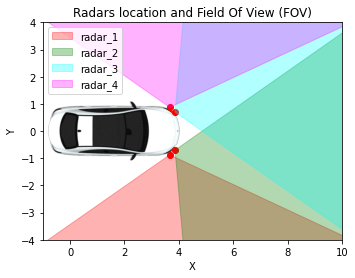

In [21]:
# Radar sensor locations
radar_sensors = []
for radars in sens_df.columns:
    radar_sensors.append([sens_df.loc['x',radars] , sens_df.loc['y',radars]])

# Field of view angles for each radar sensor
facing_angles = sens_df.loc["yaw"].values
fov_angle = [m.radians(-60), m.radians(60)]
radars_coverage = [(fov_angle[0]+x, fov_angle[1]+x) for x in facing_angles]

# Triangles coordinates for each radar
dist = 100
x_triang_verts_off = [(dist * np.cos(first) , dist * np.cos(second)) for first, second in radars_coverage]
y_triang_verts_off = [(dist * np.sin(first) , dist * np.sin(second)) for first, second in radars_coverage]
triang_verts = [[tuple(radar), (radar[0]+x[0],radar[1]+y[0]), (radar[0]+x[1],radar[1]+y[1])] for radar,x,y in zip(radar_sensors,x_triang_verts_off,y_triang_verts_off)]

# Radar labels
radar_names = sens_df.columns.tolist()
label_pos = [(2*np.cos(angle) + coord[0], 2*np.sin(angle) + coord[1]) for angle, coord in zip(facing_angles, radar_sensors)]

# Ego-vehicle image
image_path = 'carFigure.png'  
image = img.imread(image_path)
image_box = [-1, 4.2, -2.5, 2.5]

fig, axes = plt.subplots()

# Plot the radar sensor locations
axes.scatter(*zip(*radar_sensors), color = 'red')

# Plot the fovs
patches = []
colors = ['red', 'green', 'cyan', 'magenta']
for triangle,col in zip(triang_verts,colors):
    fov = Polygon(triangle, closed = True, fill = True, alpha = 0.3, color = col)
    axes.add_patch(fov)
    patches.append(fov)
    

# Plot ego-vehicle image
plt.imshow(image, extent = image_box)

# Plot settings
axes.set_xlim(-1, 10)
axes.set_ylim(-4, 4)
axes.set_xlabel('X')
axes.set_ylabel('Y')
axes.set_title('Radars location and Field Of View (FOV)')

plt.legend(handles = patches, labels = radar_names)
plt.show()

As it is possible to see from the figure, almost every point in the front half of the car plane is covered by at least two sensors FOV. The overlap of the sensors field of view permits to obtain more detections, at different angles, of the same target and permits then to reveal the target coordinates. "radar_1" and "radar_4" cover the lateral detection zone of the vehicle, while "radar_2" and "radar_3" observe the front detection zone. The redundancy in the front detection zone should permit to obtain a higher accuracy on target classification and detection.

### Radar and odometer datas:

With the function previously defined we can create a dataset representing a portion of the complete dataset, on which the data analysis will be performed. To do so, we consider at least an half portion of the available scenes stored in the dataset and labeled as 'train', since we do not want to be biased by the test datas. This kind of bias is called "data snooping bias", and occurs to the programmer when his future design decisions are made considering all datas available. Test datas must remain unknown to the programmer until the testing phase. We proceed by consider an increasing random portion of the available sequences until at least a tenth of the available scenes are included, then we create our evaluation dataset:

In [22]:
half_scenes = round(seq_df['n_scenes'].sum()/2)
total_scenes = 0
sequences = []

random.seed(6)

while total_scenes < half_scenes:
    sequences.append(random.sample(seq_df.loc[seq_df['category'] == 'train'].index.values.tolist(),1)[0])
    total_scenes = seq_df.loc[sequences, 'n_scenes'].sum()
    
print("Fifth of the total number of scenes: ", half_scenes)
print("Total scenes considered in the selection: ", total_scenes)

Fifth of the total number of scenes:  416411
Total scenes considered in the selection:  418639


In [23]:
sample_df = extractSequences(sequences)
sample_df

sensor_id   range_sc  azimuth_sc  \
sequence     scene      detection                                     
sequence_119 scene_1    1                  4   2.881374    0.285827   
                        2                  4  15.289001   -0.297277   
                        3                  4  10.781900    0.093017   
                        4                  4  12.599915    0.084568   
                        5                  4  14.654150   -0.123209   
...                                      ...        ...         ...   
sequence_76  scene_3721 179                2  37.637039    0.379650   
                        180                2  43.321655    0.394234   
                        181                2  45.675953    0.389844   
                        182                2  85.053535    0.422015   
                        183                2  90.114044    0.420525   

                                         rcs  vr_compensated       x_cc  \
sequence     scene      detection                                         
sequence_119 scene_1    1         -30.121658       -0.000646   3.093297   
                        2           1.260423       -0.007409   9.391788   
                        3         -18.067299       -0.001199   3.595928   
                        4          -0.675545       -0.001239   3.691082   
                        5         -11.550566       -0.194816   6.717877   
...                                      ...             ...        ...   
sequence_76  scene_3721 179        -4.560081        0.055357  41.436905   
                        180        -7.447220        1.449049  47.143539   
                        181         1.870193        0.061550  49.486919   
                        182         7.259903        0.046225  88.904999   
                        183        14.709221        0.055113  93.962997   

                                        y_cc track_id  label_id     vx  \
sequence     scene      detection                                        
sequence_119 scene_1    1           3.697492                 11  0.000   
                        2          15.048139                 11  0.000   
                        3          11.654692                 11  0.000   
                        4          13.472883                 11  0.000   
                        5          15.205195                 11  0.000   
...                                      ...      ...       ...    ...   
sequence_76  scene_3721 179        -2.826717                 11  4.205   
                        180        -2.516895                 11  4.205   
                        181        -2.815929                 11  4.205   
                        182        -1.905211                 11  4.205   
                        183        -2.111216                 11  4.205   

                                   yaw_rate  
sequence     scene      detection            
sequence_119 scene_1    1         -0.000349  
                        2         -0.000349  
                        3         -0.000349  
                        4         -0.000349  
                        5         -0.000349  
...                                     ...  
sequence_76  scene_3721 179       -0.000698  
                        180       -0.000698  
                        181       -0.000698  
                        182       -0.000698  
                        183       -0.000698  

[44870003 rows x 11 columns]

As a safety measure, we check if "NaN" values are present. Since we added a NaN-removal procedure to the dataset extraction we expect the following test to fail: 

In [24]:
print("\"sample_df\" contains NaN values: " + str(sample_df.isnull().values.any()) + ".")

"sample_df" contains NaN values: False.


The raw dataset columns values are then converted to user-friendly quantities to achieve a clearer comprehension.<br>
The numerical labels of the 'label_id' column are converted to the corresponding target class strings, the speeds 'vr_compensated' and 'vx' are converted from m/s to km/h, the angular speed 'yaw_rate' is converted from rad/s to deg/s and the 'azimuth_sc' angles are converted from radiants to degrees.

In [25]:
label_map = {0: 'car', 1: 'large vehicle', 2: 'truck', 3: 'bus', 4: 'train', 5: 'bicycle', 6: 'motorized two-wheeler',
             7: 'pedestrian', 8: 'group of pedestrians', 9: 'animal', 10: 'other', 11: 'static'}

sample_df['label_id'] = sample_df['label_id'].map(label_map)

sample_df[['azimuth_sc','yaw_rate']] = np.degrees(sample_df[['azimuth_sc','yaw_rate']])
sample_df[['vr_compensated','vx']] = sample_df[['vr_compensated','vx']] * 3.6
sample_df

sensor_id   range_sc  azimuth_sc  \
sequence     scene      detection                                     
sequence_119 scene_1    1                  4   2.881374   16.376688   
                        2                  4  15.289001  -17.032701   
                        3                  4  10.781900    5.329493   
                        4                  4  12.599915    4.845366   
                        5                  4  14.654150   -7.059348   
...                                      ...        ...         ...   
sequence_76  scene_3721 179                2  37.637039   21.752317   
                        180                2  43.321655   22.587927   
                        181                2  45.675953   22.336432   
                        182                2  85.053535   24.179686   
                        183                2  90.114044   24.094288   

                                         rcs  vr_compensated       x_cc  \
sequence     scene      detection                                         
sequence_119 scene_1    1         -30.121658       -0.002327   3.093297   
                        2           1.260423       -0.026671   9.391788   
                        3         -18.067299       -0.004316   3.595928   
                        4          -0.675545       -0.004461   3.691082   
                        5         -11.550566       -0.701338   6.717877   
...                                      ...             ...        ...   
sequence_76  scene_3721 179        -4.560081        0.199284  41.436905   
                        180        -7.447220        5.216576  47.143539   
                        181         1.870193        0.221582  49.486919   
                        182         7.259903        0.166408  88.904999   
                        183        14.709221        0.198405  93.962997   

                                        y_cc track_id label_id      vx  \
sequence     scene      detection                                        
sequence_119 scene_1    1           3.697492            static   0.000   
                        2          15.048139            static   0.000   
                        3          11.654692            static   0.000   
                        4          13.472883            static   0.000   
                        5          15.205195            static   0.000   
...                                      ...      ...      ...     ...   
sequence_76  scene_3721 179        -2.826717            static  15.138   
                        180        -2.516895            static  15.138   
                        181        -2.815929            static  15.138   
                        182        -1.905211            static  15.138   
                        183        -2.111216            static  15.138   

                                   yaw_rate  
sequence     scene      detection            
sequence_119 scene_1    1             -0.02  
                        2             -0.02  
                        3             -0.02  
                        4             -0.02  
                        5             -0.02  
...                                     ...  
sequence_76  scene_3721 179           -0.04  
                        180           -0.04  
                        181           -0.04  
                        182           -0.04  
                        183           -0.04  

[44870003 rows x 11 columns]

We proceed with the evaluation of the datas. With the following methods, info() describe() and value_count(), is possible to obtain precious informations about the datas.

In [26]:
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 44870003 entries, ('sequence_119', 'scene_1', 1) to ('sequence_76', 'scene_3721', 183)
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   sensor_id       uint8  
 1   range_sc        float32
 2   azimuth_sc      float32
 3   rcs             float32
 4   vr_compensated  float64
 5   x_cc            float32
 6   y_cc            float32
 7   track_id        object 
 8   label_id        object 
 9   vx              float64
 10  yaw_rate        float64
dtypes: float32(5), float64(3), object(2), uint8(1)
memory usage: 2.8+ GB


In [27]:
sample_df[['range_sc','azimuth_sc','rcs','vr_compensated','x_cc','y_cc','vx','yaw_rate']].describe()

,range_sc,azimuth_sc,rcs,vr_compensated,x_cc,y_cc,vx,yaw_rate
count,4.487000e+07,4.487000e+07,4.487000e+07,4.487000e+07,4.487000e+07,4.487000e+07,4.487000e+07,4.487000e+07
mean,2.794325e+01,1.697704e+00,-6.590532e+00,3.890080e-01,1.943741e+01,1.873263e+00,2.785699e+01,-1.044031e-01
std,2.383958e+01,2.442798e+01,1.114547e+01,8.836917e+00,2.370309e+01,2.752577e+01,2.339217e+01,4.573519e+00
min,3.499990e-01,-6.999990e+01,-3.059994e+01,-3.911927e+02,-8.630663e+01,-1.006164e+02,-9.720000e-01,-3.273000e+01
25%,1.334676e+01,-1.631478e+01,-1.570035e+01,-1.286668e-01,4.909123e+00,-1.186697e+01,5.364000e+00,-3.700000e-01
50%,2.694694e+01,1.975314e+00,-8.263966e+00,5.316772e-03,1.486220e+01,2.938226e+00,2.473200e+01,0.000000e+00
75%,5.012767e+01,1.972139e+01,5.048727e-01,1.589005e-01,3.480200e+01,1.600517e+01,4.363200e+01,3.800000e-01
max,9.975045e+01,6.999995e+01,5.615566e+01,4.071020e+02,1.036082e+02,1.006153e+02,9.054000e+01,3.311000e+01


With the describe() method is possible to evaluate some basic statistics about the acquired measures.

From the 'range_sc' column we can confirm that the maximum detection range of the radars is around 100m, as stated in the reference article.<br> 
The maximum and minimum 'azimuth_sc' values indicates a FOV for the radars of about ±70°, differently from the value reported in the article of ±60°.<br>
The maximum and minimum values of the 'vr_compensated' column seems very high, they could be outlayers due to wrong measurements. This evidence remarks the need to perform an outlayer removal operation on the various measurements, in addition to an accurate analysis of the measure 'vr_compensated'.<br>
The values reported in the 'vx' column highlights a maximum speed while measuring of 90 km/h for the ego-vehicle. The minimum speed record shows that, in the considered sequences, no reverse maneuvers have been performed.

A further investigation on the 'vr_compensated' measures is conducted. We consider the measures distribution for the detections that are related to moving targets.

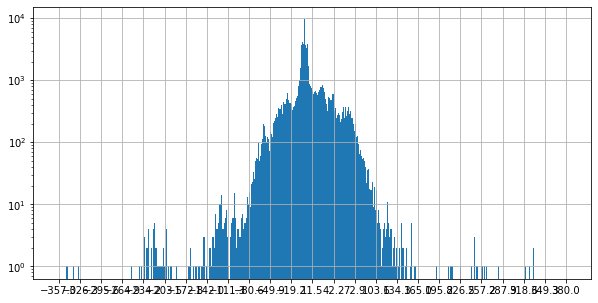

In [28]:
moving_sample_df = sample_df.query("label_id != 'static'")
plt.figure(figsize=(10,5))
plt.hist(moving_sample_df['vr_compensated'], bins=10000,log = True)
plt.xticks(np.linspace(m.ceil(moving_sample_df['vr_compensated'].min()),  m.ceil(moving_sample_df['vr_compensated'].max()), num = 25))
plt.grid(True)
plt.show()

As we can see from the previous histogram, the occurrences of speed measures out of the interval [-80,100] km/h are quite rare. We verify to which detections the radial speeds out of the interval are related.

In [29]:
moving_sample_df.query("vr_compensated > 90 | vr_compensated < -90")['label_id'].value_counts()

car                      6064
truck                    2200
group of pedestrians      665
bus                       352
bicycle                   338
other                     239
large vehicle             208
pedestrian                186
motorized two-wheeler       2
animal                      1
Name: label_id, dtype: int64

It is clear that these measurements are outlayers, since are reported pedestrians, group of pedestrians and bicycles. To perform an outlayer removal action, we look for the maximum admittable velocities for each category.

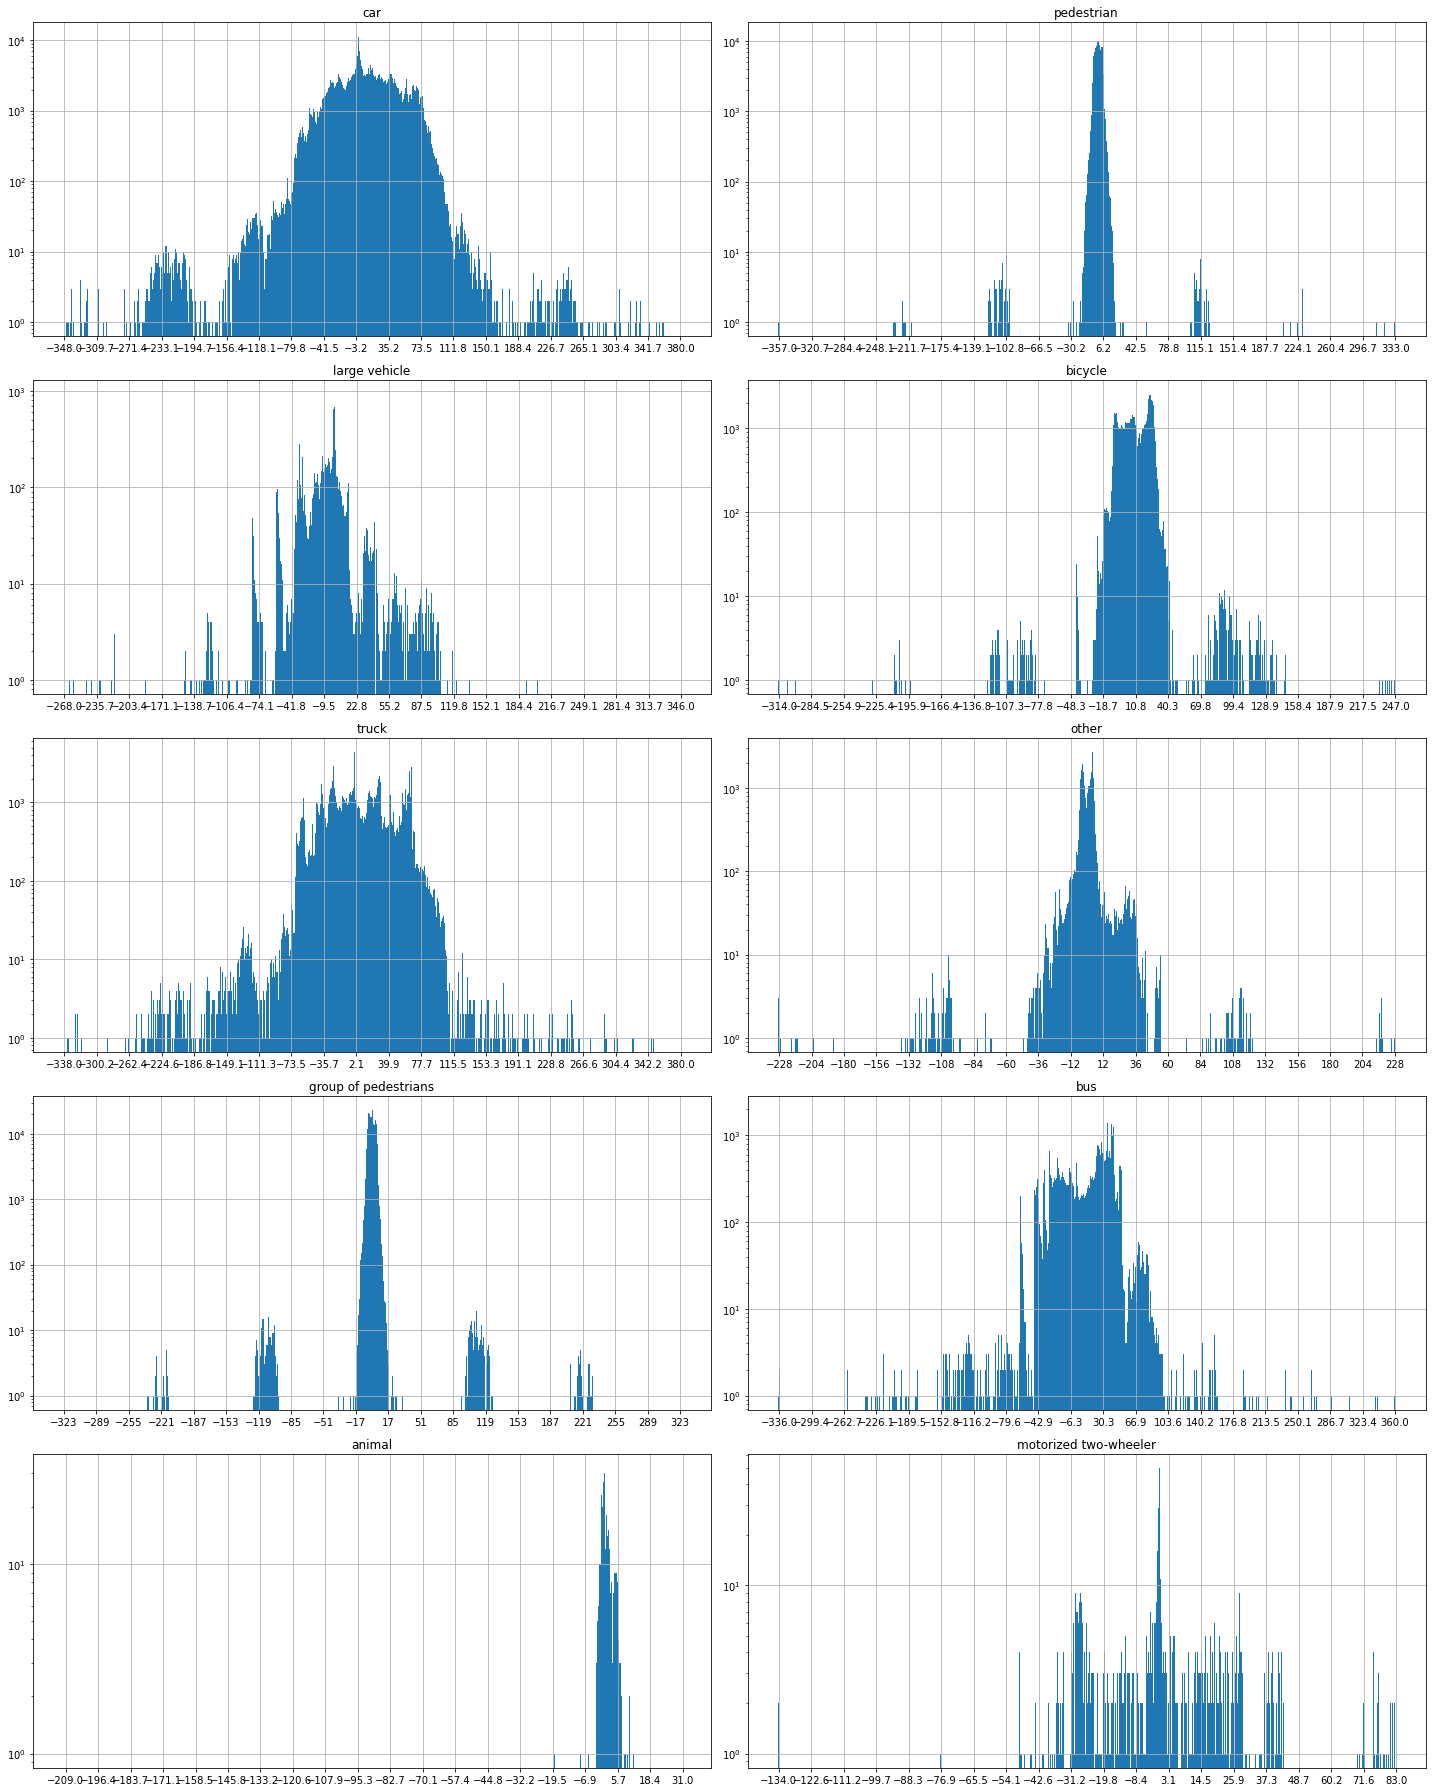

In [30]:
targets = [(label,moving_sample_df[moving_sample_df['label_id'] == label]['vr_compensated'].tolist())
              for label in moving_sample_df['label_id'].unique()]

figure, plots = plt.subplots(round(len(targets)/2), 2, figsize=(20, 25))

for i, speeds in enumerate(targets):
    plot = plots[i // 2, i % 2]
    plot.hist(speeds[1], bins = 1000, log = True)  
    plot.set_title(speeds[0])
    plot.set_xticks(np.linspace(m.ceil(min(speeds[1])), m.ceil(max(speeds[1])), num = 20))
    plot.grid(True)

plt.tight_layout()
plt.show()

Observing the previous graphs we can define the following admitted speed intervals for each category:
* 'other': we choose to keep all the detections, since we have no clue on what kind of objects falls in the category;<br>
* 'group of pedestrians': seems reasonable to keep detection in the [-15,15] km/h;<br>
* 'pedestrian': like the 'group of pedestrians' category, the interval [-15,15] km/h is considered;<br>
* 'bycicle': from the data distribution, a positive boundary of 50 km/h seems to be reasonable. We are looking for simmetric intervals since the target forward direction of moving is unknown, so a [-50,50] km/h is considered;<br>
* 'truck': a reasonable interval of [-100,100] km/h is considered;<br>
* 'car': the distribution suggests the [-140,140] km/h interval;<br>
* 'bus': like the 'truck' category, an interval of [-100,100] km/h is considered;<br>
* 'motorized two-wheeler': the histogram highlights a low number of detections for this category. An interval of [-140,140] km/h like the 'car' category seems reasonable;<br>
* 'animal': the histogram shows a low number of detections. Considering animals like horses, an interval of [-40,40] km/h is chosen;<br>
* 'large vehicle': under this category falls vehicles like agricultural or construction ones, so an interval of [-90,90] km/h seems reasonable;

A dictionary with the intervals limits is defined and applied to the 'sample' dataframe.

In [31]:
speed_map = {'car': (-140,140), 'large vehicle': (-90,90), 'truck': (-100,100), 'bus': (-100,100), 'bicycle': (-50,50), 
             'motorized two-wheeler': (-140,140), 'pedestrian': (-15,15), 'group of pedestrians': (-15,15), 'animal': (-40,40)}

to_drop = np.zeros(len(sample_df), dtype=bool)

for category, (inf, sup) in speed_map.items():
    mask = (sample_df['label_id'] == category) & ((sample_df['vr_compensated'] < inf) | (sample_df['vr_compensated'] > sup))
    to_drop |= mask

sample_df.drop(sample_df[to_drop].index, inplace=True)

To verify the results, we plot again the speed distributions for the moving targets.

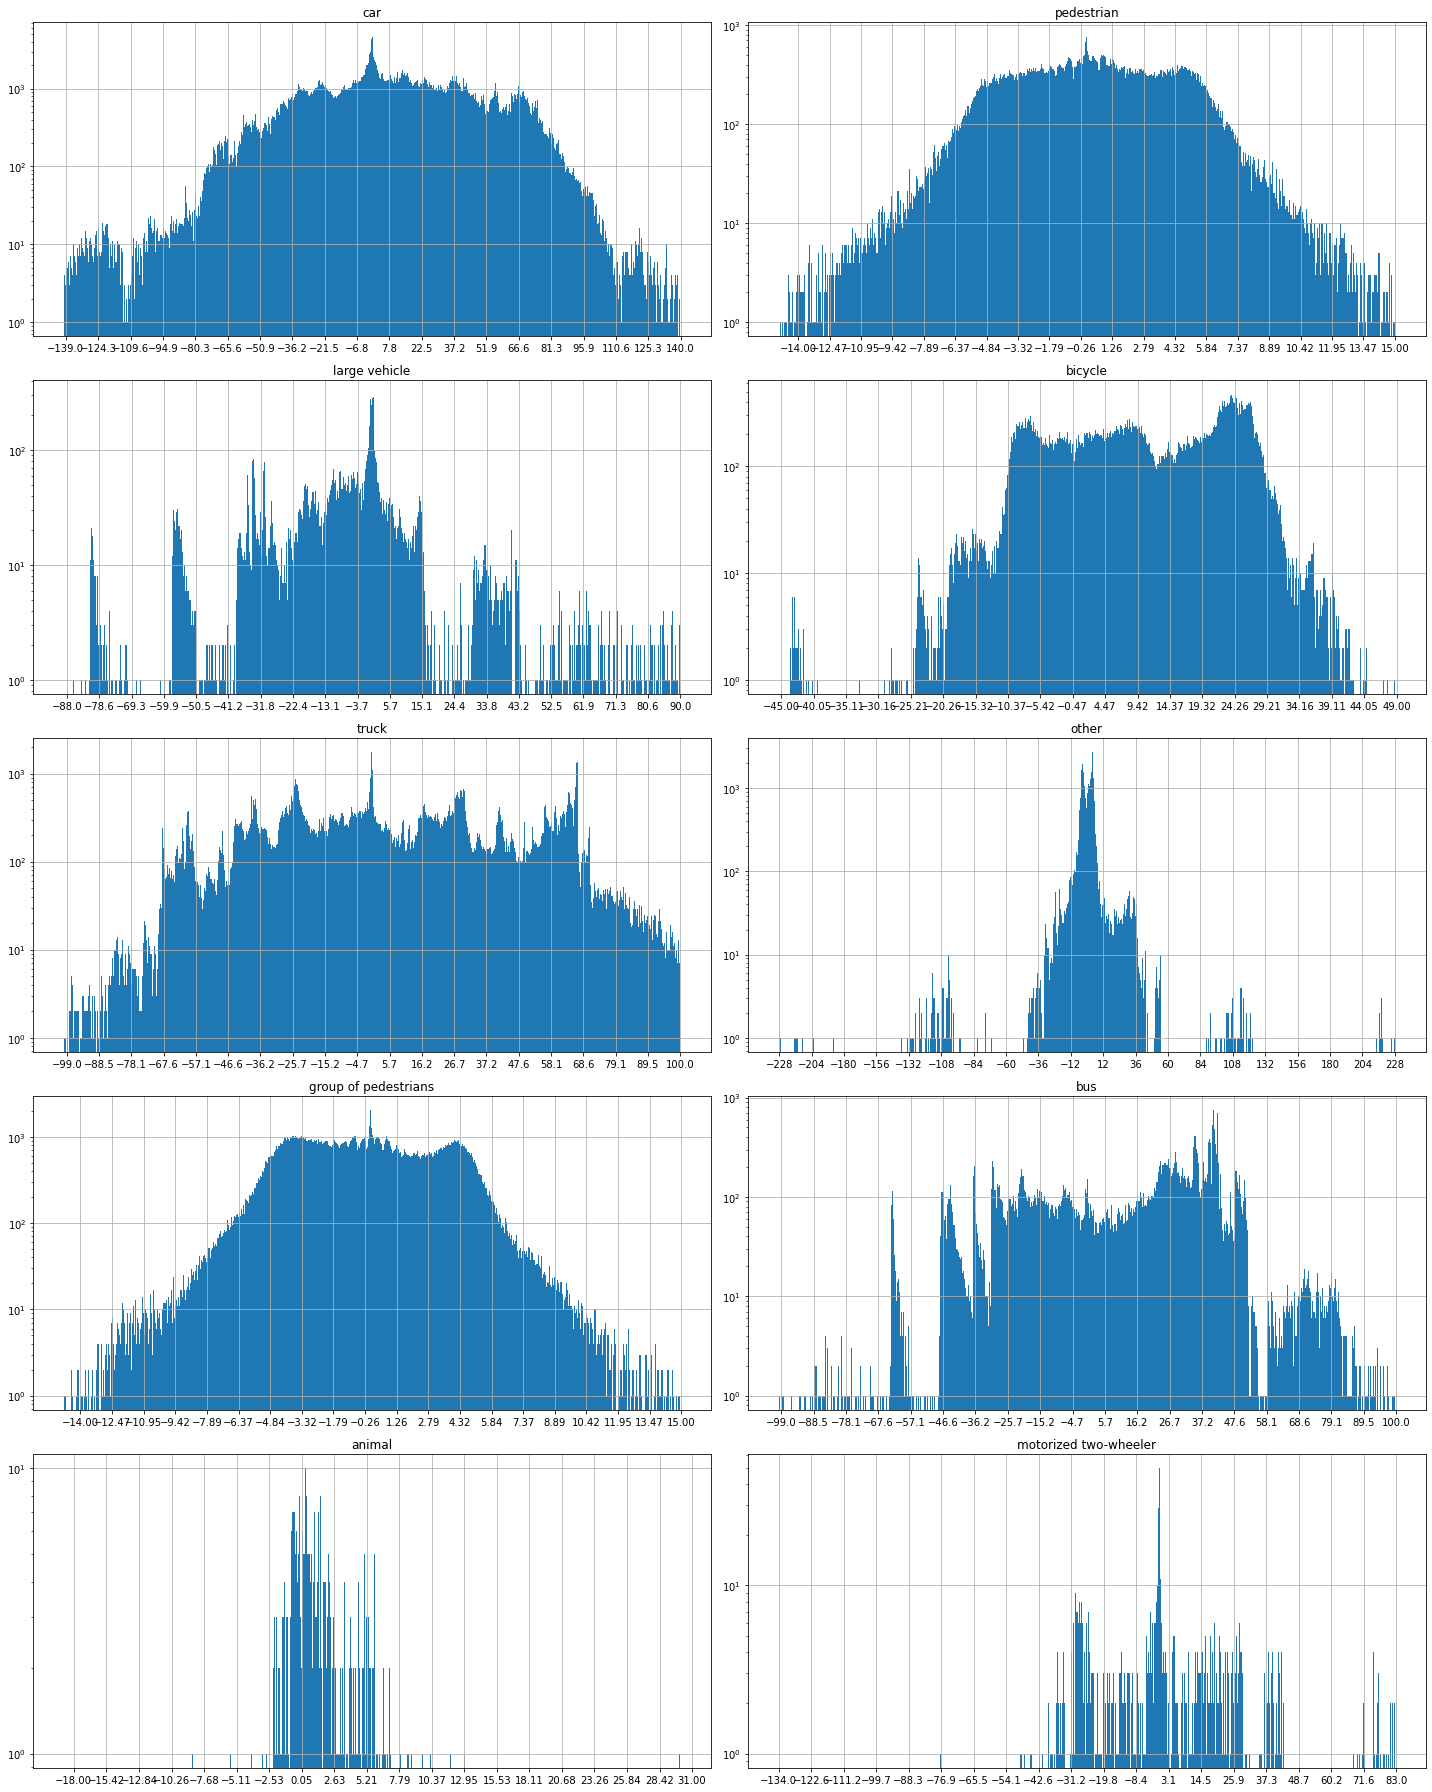

In [32]:
moving_sample_df = sample_df.query("label_id != 'static'")

targets = [(label,moving_sample_df[moving_sample_df['label_id'] == label]['vr_compensated'].tolist())
              for label in moving_sample_df['label_id'].unique()]

figure, plots = plt.subplots(round(len(targets)/2), 2, figsize=(20, 25))

for i, speeds in enumerate(targets):
    plot = plots[i // 2, i % 2]
    plot.hist(speeds[1], bins = 1000, log = True)  
    plot.set_title(speeds[0])
    plot.set_xticks(np.linspace(m.ceil(min(speeds[1])), m.ceil(max(speeds[1])), num = 20))
    plot.grid(True)

plt.tight_layout()
plt.show()

As expected, all outlayers of the categories specified in the speed_map have been removed. We proceed to observe the remaining columns of the dataset.

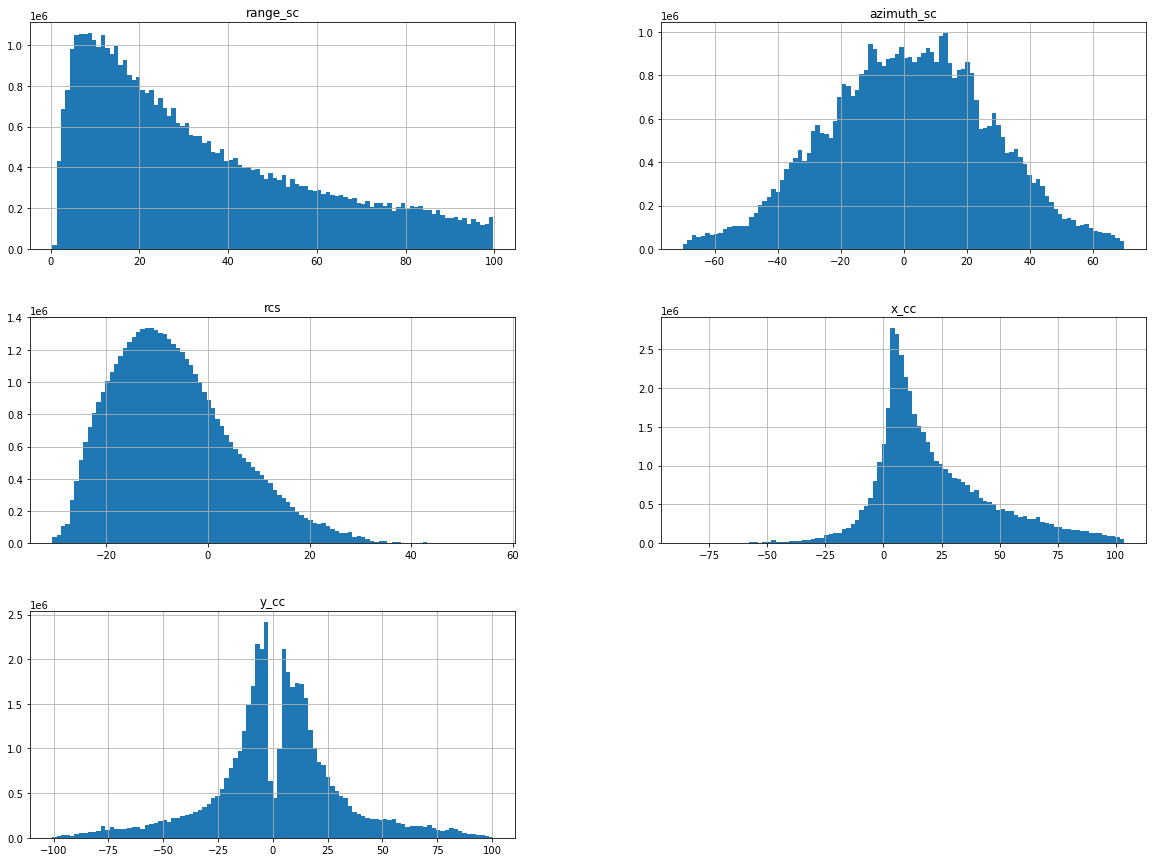

In [33]:
sample_df[['range_sc','azimuth_sc','rcs','x_cc','y_cc']].hist(bins=100, figsize=(20,15));

In the 'range_sc' column it is possible to see that most detections belongs to targets near to the radars.<br> 
The distribution of the 'rcs' samples is not uniform, probably because each object presents a typical range of rcs and the proportion of different targets is uneven in the dataset, with a higher number of cars than the remaining categories.<br>
The 'azimuth_sc' datas presents an almost gaussian distribution with mean 0, meaning that the targets presented themselves equally on each side of the sensors.<br> 
From the spatial datas 'x_cc' and 'y_cc' we can observe that lots of detections occurs in the near space in front of the car, following the decreasing trend of 'range_sc' for major distances. On the lateral axis we can see that detections on the right side, near the car, are more frequent: that is a sign of a right-hand drive scenario, where all the detections related to targets on the sidewalk appear closer to the vehicle.<br>

We observe a map representing the targets distributions in the space, considering the ego-vehicles coordinate system.

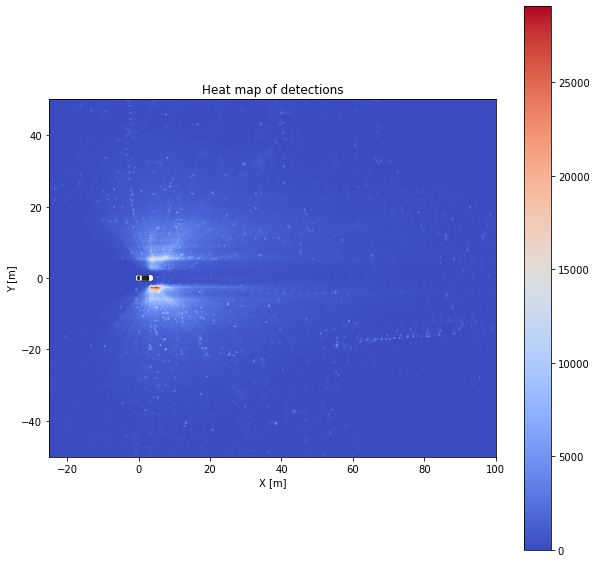

In [34]:
# Heatmap
heatmap, x_edge, y_edge = np.histogram2d(sample_df['x_cc'], sample_df['y_cc'], bins=500)

# Ego-vehicle
image_path = 'carFigure.png'  
image = img.imread(image_path)
image_box = [-1, 4.2, -2.5, 2.5]

figure, axes = plt.subplots(figsize=(10, 10))

axes.imshow(image, extent=image_box, zorder=1)
im_ref = axes.imshow(heatmap.T, extent=[x_edge.min(), x_edge.max(), y_edge.min(), y_edge.max()], origin='lower', cmap='coolwarm', zorder=0)

axes.set_xlim(-25, 100)
axes.set_ylim(-50, 50)
axes.set_xlabel('X [m]')
axes.set_ylabel('Y [m]')
axes.set_title('Heat map of detections')

# Color bar
color_bar = fig.colorbar(im_ref, ax=axes)

plt.show()

The heatmap confirms our hypothesis: on the right side of the car the nearest detections appears at a lower distance than the ones on the left side. The right ones are almost certainly due to targets on the sidewalk, while the left ones arise from targets proceeding on the opposite lane.

We proceed on the dataset evaluation considering the remaining categorical columns of the dataframe.

In [35]:
sample_df['sensor_id'].value_counts()

3    12987214
2    11986657
4    10261544
1     9630096
Name: sensor_id, dtype: int64

We can see that most detections are made by the "front" radar mounted on the left side of the car, followed by its right counterpart. This makes sense, since the radars 3 and 2 have a FOV that covers the direction in which the ego-vehicle is proceeding and then detect all the approcing targets (multiple times). The radar_3 is responsible for a slightly higher number of detections, probably because most of them are obtained from all the vehicles moving on the opposite lane.

We proceed by evaluating for each of the radar sensors the proportion of detected targets categories, considering only the moving objects:

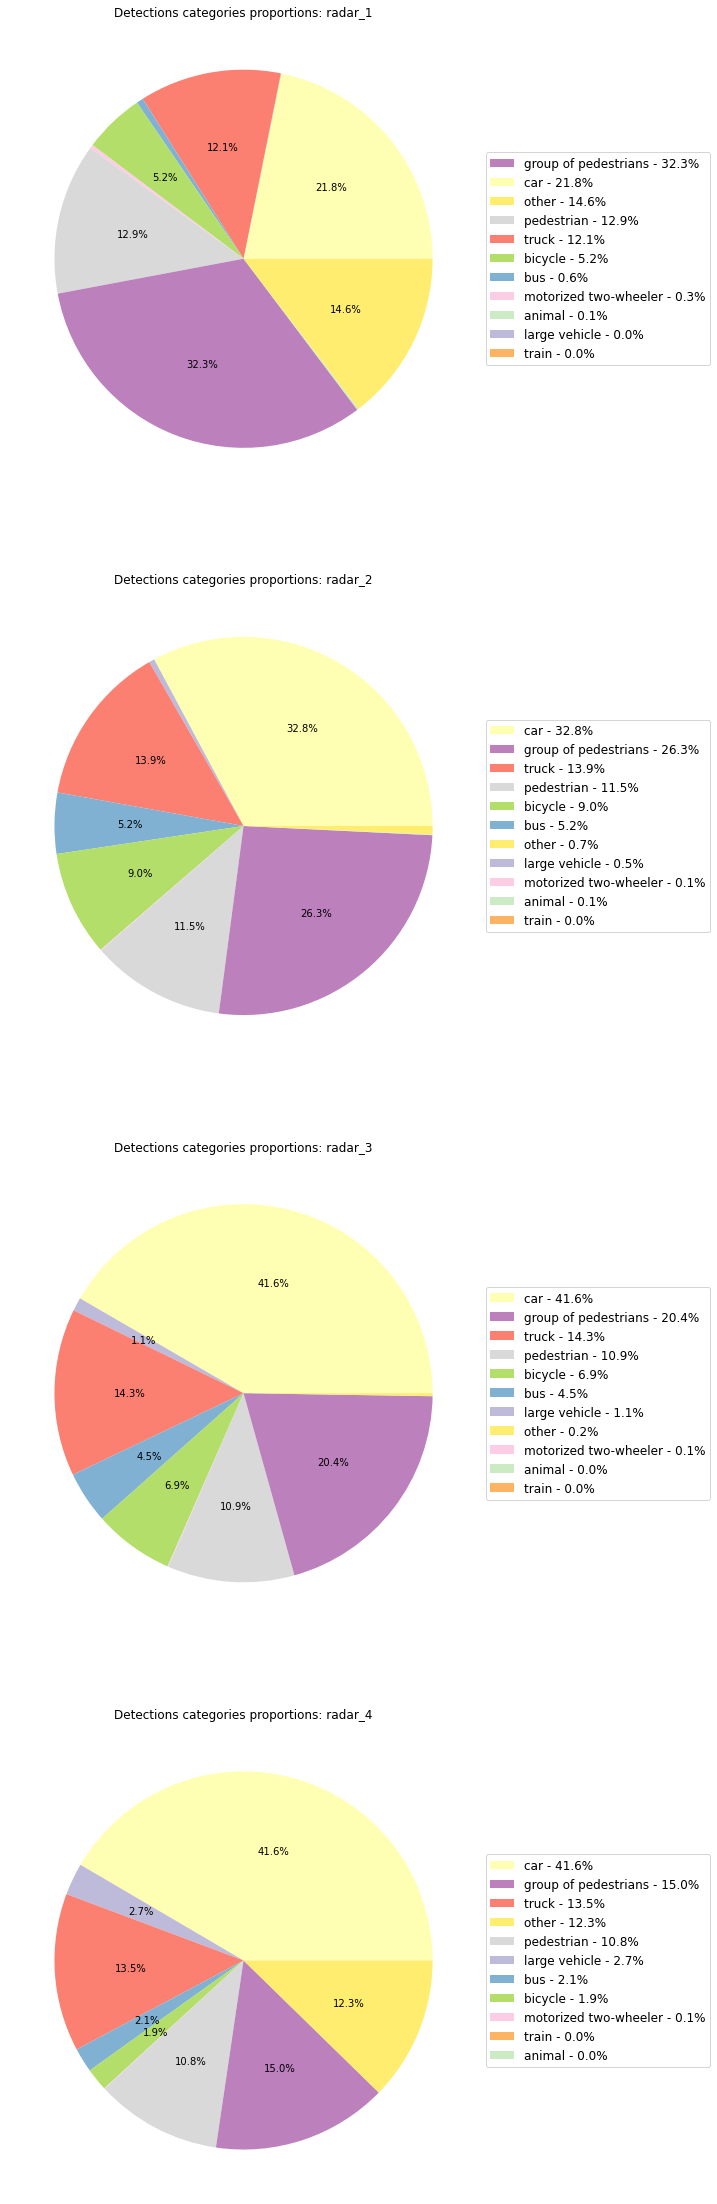

In [96]:
# Specifies possible labels
all_labels = ['car', 'large vehicle', 'truck', 'bus', 'train', 'bicycle', 'motorized two-wheeler',
              'pedestrian', 'group of pedestrians', 'animal', 'other']

# Creates subplots
fig, axes = plt.subplots(sample_df['sensor_id'].nunique(), 1, figsize=(10, 40))

# Using flatten we can iterate over the subplots linearly
axes = axes.flatten()

for radar in np.sort(sample_df['sensor_id'].unique()):

    # Get the number of different labels occurrences for the i-th sensor, excluding the 'static' object
    radar_i = sample_df[sample_df['sensor_id'] == radar]
    occurrences = radar_i['label_id'].value_counts()
    occurrences.drop('static', inplace = True)
    
    # Constructs a series with the possible labels as index and zeros as values, then fills the the fields with
    # the number of occurrences for each label
    detections = pd.Series(index=all_labels, dtype=int).fillna(0)
    detections.update(occurrences)
    
    # Builds a color list to achieve a consistent association label-color for all the pie charts
    colors = plt.cm.Set3.colors[1:len(all_labels)+1]
    
    # Builds the pie chart showing only the percentages over 1% to avoid overlapping
    axes[radar-1].pie(detections, autopct=lambda pct: f'{pct:.1f}%' if pct >= 1 else '', colors = colors)
    axes[radar-1].set_title("Detections categories proportions: " + sens_df.columns[radar-1])
    axes[radar-1].set_aspect('equal')
    
    # Builds the legend sorting in descending order all the percentages, labels and colors sets based on
    # the percentages values
    percentages = 100 * detections.values / sum(detections.values)
    labels = detections.index
    colors, labels, percentages = zip(*sorted(zip(colors, labels, percentages), key=lambda x: x[2], reverse=True))
    rect_colors = [plt.Rectangle((0, 0), 1, 1, fc=color) for color in colors]
    legend_labels = ['{0} - {1:1.1f}%'.format(label, percentage) for label, percentage in zip(labels, percentages)]
    axes[radar-1].legend(rect_colors,legend_labels, loc='center right', bbox_to_anchor=(1.5, 0.5), fontsize='large')

# Reduces the distance between plots
plt.subplots_adjust(hspace=0.2)
plt.show()

From the previous pie charts it is possible to see that the most frequently detected objects are cars and groups of pedestrian.
The sensor 'radar_1' detects mostly groups of pedestrian since its covered area is the right side of the ego-vehicle, pointing right to the nearest sidewalk of the road.<br>
The "left" sensors, 'radar_3' and 'radar_4', detects instead a lot of vehicles in respect to the other two sensors and this makes sense since they are pointing on the left side of the car, covering the opposite lane area.<br>
 
The static objects have been removed from the previous analysis. They are not desired in this dataset since it is incentrated on moving objects, but are very common in the scenes and for each radar they represents over 95% of the detections, as summarized below:

In [95]:
for radar in np.sort(sample_df['sensor_id'].unique()):
    radar_i = sample_df[sample_df['sensor_id'] == radar]
    occurrences = radar_i['label_id'].value_counts()
    percentage = 100 * occurrences['static'] / sum(occurrences.values)
    print('radar_{0} proportion of static objects: {1:1.1f}%'.format(radar, percentage))

radar_1 proportion of static objects: 98.9%
radar_2 proportion of static objects: 95.9%
radar_3 proportion of static objects: 95.5%
radar_4 proportion of static objects: 98.4%


The last column of the dataset to analize is the 'track_id' column. We exclude from the evaluation all the detections that are not related to tracked object, characterized by an empty string as 'track_id'.

In [165]:
sample_df['track_id'].value_counts().drop("")

9e07871c898011e78bcf38d547008930    13205
59bfb37050f711e7b88c38d547008930    13154
33e8e8e0897a11e7b4a638d547008930    12831
efc6b57c88c711e8a97c1831bfce0046    11858
5e8416f4832d11e785f5080027db4947    11713
                                    ...  
9c4ef558a6cc11e8a69f08002763e0da        2
443bb95aee2f11e8aca0ecf4bb13c459        1
dab59620e67e11e8857008002763e0da        1
1e5f44f8688a11e7851b080027db4947        1
e652dc4a2c0811e78f283085a997fbb5        1
Name: track_id, Length: 2482, dtype: int64

In [170]:
print("Detections for tracked objects: ", len(sample_df[sample_df['track_id'] != '']), "({0: .3f}%)".format(100 * len(sample_df[sample_df['track_id'] != '']) / len(sample_df)))

Detections for tracked objects:  1341256 ( 2.990%)


The detections related to tracked objects are only approximately the 3% of the available detections.<br>
We proceed by looking for the total number of tracked objects and some statistics about the number of detections for each target:

In [171]:
n_detections = sample_df['track_id'].value_counts().drop("")
n_detections.describe()

count     2482.000000
mean       540.393231
std       1122.808346
min          1.000000
25%         51.000000
50%        217.500000
75%        539.000000
max      13205.000000
Name: track_id, dtype: float64

It is possible to see that in this case we have a total of 2482 different tracked objects. We can see that the number of detections for each object ranges from 13205 to 1, with a 75% percentile of 539. This should suggest that a little number of objects presents more than 540 detections (mean value) and so the distribution should be very uneven.<br>
With the percentiles informations we can make the following consideration:

In [172]:
print("Objects with over {0} detections: {1} (25%)".format(n_detections.quantile(0.75), len(n_detections) * 0.25))
print("Objects with less than {0} detections: {1} (75%)".format(n_detections.quantile(0.75), len(n_detections) * 0.75))

Objects with over 539.0 detections: 620.5 (25%)
Objects with less than 539.0 detections: 1861.5 (75%)


The two previous statements reports the fact that a quarter of the tracked objects have more than 539 detections, while the larger part of them presents less detections.<br>
With the following graph is possible to give a visual representation of the number of detections for each tracked object:

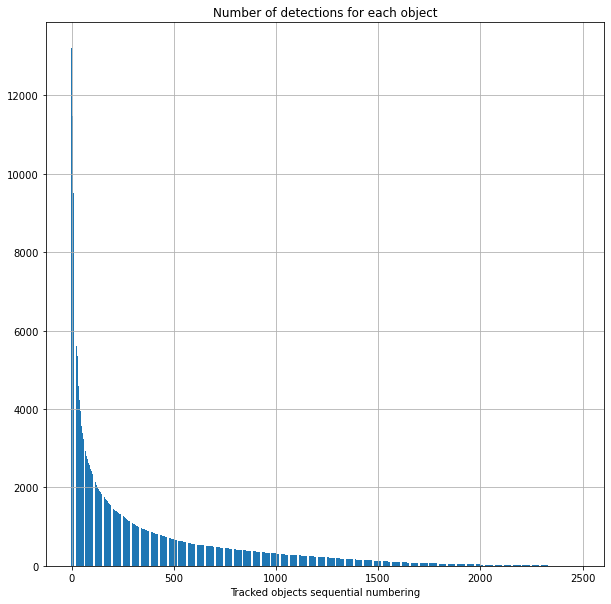

In [173]:
figure, axes = plt.subplots(figsize=(10, 10))

progressive_numbering = range(len(n_detections))

axes.bar(progressive_numbering, n_detections.values)

axes.set_title('Number of detections for each object')
axes.set_xlabel('Tracked objects sequential numbering')
axes.grid(True)

plt.show()

From the graph we can see that the mean value for the number of detections is misleading, since the mean is conditioned from the few objects with a really high number of detections.<br> Probably the tracked objects with a high number of detections are vehicles that proceeded in front of the ego-vehicle for a long time.<br> To test this hypothesis, we consider the class labels of the ten tracked objects with the highest number of detections:

In [186]:
for obj in n_detections.index[1:11]:
    label = sample_df.loc[sample_df['track_id'] == obj, 'label_id'].unique()
    print(label[0], "object detections: {0}".format(len(sample_df[sample_df['track_id'] == obj])))

bicycle object detections: 13154
bus object detections: 12831
bicycle object detections: 11858
bus object detections: 11713
truck object detections: 11485
car object detections: 11385
truck object detections: 11225
bicycle object detections: 9701
car object detections: 9630
bicycle object detections: 9516


As we can see, the top ten tracked objects with most detections are all vehicles compatible with the hypothesis.

## Classification features

As a final parentheses about the evaluation of the available datas, we consider briefly the two columns of our dataset that we plain to use next as main feature for the classification application: the target RCS and radial speed.<br>
These two feature plus the distance from the sensor represents the only three informations about an unknown target in space that can be obtained by using radar sensors.<br>

The RCS, namely Radar Cross Section, is expressed as an area and represent the cross-sectional area of a perfectly reflective sphere that would produce a back-scattered wave with the same power density as the one produced by the target. It is calculated considering the measured power density of the back-scattered field from the target and its radial distance, assuming an isothropic propagation of the EM waves. The RCS is usually directly reported in square meters or alternatively in dBsm, namely dB per square meter (power per unit area).<br>
The RCS measure is highly variable with the target's materials and shape, which condition the scattering phenomenon of the EM waves produced by the target. Thus, the RCS obtained for a specific object varies considerably with the angle from which it is observed, so that usually the RCS of an objects is reported as a diagram where this value is expressed from all the possible view angles.<br>

For each target category we report a simple statistical summary for the RCS measures. The quantities are expressed in square meters to consider a linear scale instead of a logarithmic one.

In [212]:
# Extracts RCS values for each target category
rcs_cat = sample_df.groupby('label_id')['rcs'].apply(list).to_dict()
del rcs_cat['static']

for category in rcs_cat.keys():

    # dBsm to square meters conversion
    rcs_values = np.power(10, np.array(rcs_cat[category]) / 10)
    
    print("Statistical summary for "+category+" RCS:")
    print(pd.Series(rcs_values).describe())
    print()

Statistical summary for animal RCS:
count    492.000000
mean       0.130197
std        0.223310
min        0.002121
25%        0.017215
50%        0.051634
75%        0.138327
max        2.461742
dtype: float64

Statistical summary for bicycle RCS:
count    92803.000000
mean         0.276082
std          2.184319
min          0.000878
25%          0.024583
50%          0.074109
75%          0.214208
max        303.173985
dtype: float64

Statistical summary for bus RCS:
count    55711.000000
mean        65.262640
std        828.094070
min          0.000874
25%          0.165636
50%          0.655572
75%          2.960621
max      37900.400463
dtype: float64

Statistical summary for car RCS:
count    494652.000000
mean          8.355852
std          66.007596
min           0.000871
25%           0.058487
50%           0.313399
75%           2.318948
max       28895.734631
dtype: float64

Statistical summary for group of pedestrians RCS:
count    306247.000000
mean          0.679947
std  

As expected, for all categories the standard deviation is higher than the mean value and this highlights an high variability for the measure. To mitigate this phenomenon, in the following classification application we will try to consider various measures of RCS for the same target, grouped adopting a clustering algorithm in each scene.<br>

The same analisys is conducted on the radial speed measure of the target. We expect a correlation between the target category and its speed: for example, an "animal" target will surely proceed, on average, slower than a "car" target.<br>
However there are scenarios in which the proceeding pace is common for a larger variety of objects, for example the urban context where cars, buses and even bycicles often proceeds at the same speed.<br>
A further complication comes from the fact that radars are capable of measuring only the radial speed, i.e. the speed component of the object in the radar direction. This fact complicates the evaluation of the absolute target speed because we can retrieve only a partial information about it.<br>

As done before on the RCS measurements, we report a simple statistical summary for each target category. The quantities are expressed in km/h and the absolute values are considered:

In [220]:
# Extracts vr_compensated values for each target category
speed_cat = moving_sample_df.groupby('label_id')['vr_compensated'].apply(list).to_dict()

for category in speed_cat.keys():
    
    # absolute value conversion
    abs_speed = np.abs(speed_cat[category])
    
    print("Statistical summary for "+category+" radial speed:")
    print(pd.Series(abs_speed).describe())
    print()

Statistical summary for animal radial speed:
count    492.000000
mean       2.217129
std        2.572023
min        0.002242
25%        0.604818
50%        1.373090
75%        2.838625
max       30.043488
dtype: float64

Statistical summary for bicycle radial speed:
count    92803.000000
mean        13.825812
std          9.189925
min          0.000036
25%          5.942153
50%         11.228238
75%         22.753686
max         48.717046
dtype: float64

Statistical summary for bus radial speed:
count    55711.000000
mean        28.690804
std         15.331337
min          0.001185
25%         17.772871
50%         28.700793
75%         39.707513
max         99.875411
dtype: float64

Statistical summary for car radial speed:
count    494652.000000
mean         29.867429
std          23.201947
min           0.000000
25%          10.532131
50%          25.637859
75%          43.949229
max         139.951099
dtype: float64

Statistical summary for group of pedestrians radial speed:
count 

As seen previously with the RCS measurements, also the radial speeds presents high standard deviations in respect to the mean values. This occurs because of the variety of the driving scenarios, where vehicles can proceed at high speed or even stop.<br>
Anyways, a distinction between mean radial speed values for different categories is present: we can see that the mean observed speed for "pedestrian" category is around 3 km/h while for the "truck" category it is around 32 km/h. Obviously some categories presents values more similar than others, like the "pedestrian" and "group of pedestrian" categories or the "bus" and "car" categories. 

We conclude the data evaluation section with a consideration regarding the classification application. Since a single detection has features with high variablity that would lead to a weaker algorithm, we firstly apply a clustering procedure to group more detections about the same object, increasing the number of data to consider.

## Data preparation

We have to prepare our datas in order to feed them to our classification algorithm.<br>

First we define a transformer that converts our measurements in different scales, as done before in the data evaluation section.
This is done to use in the following the same reasonings previously developed. In the RCS case, the data are transformed from the logarithmic to the linear scale to have all data expressed in the linear scale. The RCS are so converted from dBsm to square meters.

In [377]:
class ScaleConversion(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        X[['azimuth_sc','yaw_rate']] = np.degrees(X[['azimuth_sc','yaw_rate']])
        X[['vr_compensated','vx']] = X[['vr_compensated','vx']] * 3.6
        X['rcs'] = np.power(10, X['rcs'].values / 10) 
        
        return X

To perform an outlayer removal operation, we assemble the following transformer that removes all 'vr_compensated' outlayers detections, as done before in the data evaluation section.

In [378]:
class OutlayerSpeeds(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # The speed intervals dictionary previously defined, having as keys the original numeric label_id
        speed_map = {0: (-140,140), 1: (-90,90), 2: (-100,100), 3: (-100,100), 5: (-50,50), 
                     6: (-140,140), 7: (-15,15), 8: (-15,15), 9: (-40,40)}

        # Outlayer removal
        to_drop = np.zeros(len(X), dtype=bool)
        
        for category, (inf, sup) in speed_map.items():
            mask = (X['label_id'] == category) & ((X['vr_compensated'] < inf) | (X['vr_compensated'] > sup))
            to_drop |= mask
            
        X.drop(X[to_drop].index, inplace=True)
        
        return X

We already included a NaN removal feature in the extraction function, so we proceed modifying our categorical column 'label_id' using one-hot-encoding.<br> 
With one-hot-encoding it is possible to expand the categorical feature in multiple columns, one per category, where a membership boolean information is stored for each detection. Since our categories are all different, this representation permits to exclude the possibility that the algorithm will consider "closer" the samples that belongs to categories that have adjacent numbers.The use of a numeric value is mandatory, since sklearn's ML algorithms cannot handle others data types.<br>
We define then the following transformer, which purpose is to convert the label_id column values with one-hot-encoding.

In [379]:
class OneHotLabels(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        categories = np.arange(12)
        self.encoder = OneHotEncoder(categories=[categories])
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        label_map = {0: 'car', 1: 'large vehicle', 2: 'truck', 3: 'bus', 4: 'train', 5: 'bicycle', 6: 'motorized two-wheeler',
             7: 'pedestrian', 8: 'group of pedestrians', 9: 'animal', 10: 'other', 11: 'static'}

        # Encodes the numerical "label_id" column
        labels_1hot = self.encoder.fit_transform(X[['label_id']])
        columns_names = [label_map[key] for key in self.encoder.categories_[0]]
        encoded_df = pd.DataFrame(labels_1hot.toarray(), columns=columns_names, index = X.index)
        
        X = X.drop('label_id', axis=1)
        
        return pd.concat([X, encoded_df], axis=1)

In order to feed our data to the ML algorithm, it is necessary to execute a feature scaling operation on each input feature.<br> To do so, the following transformer is defined. We choose to use normalization on the columns that have a clear interval of values, limited by the system like 'azimuth_sc' or by our operations like 'vr_compensated'. On the other columns we use standardization.

In [380]:
class FeatureScaling(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.norm_encoder = MinMaxScaler()
        self.std_encoder = StandardScaler()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        norm_encoder = MinMaxScaler()

        # Normalization on  range_sc, azimuth_sc, vr_compensated, x_cc, y_cc
        norm_columns = ['range_sc', 'azimuth_sc', 'vr_compensated', 'x_cc', 'y_cc']
        X[norm_columns] = norm_encoder.fit_transform(X[norm_columns])

        # Standardization for rcs, vx, yaw_rate
        stand_columns = ['rcs', 'vx', 'yaw_rate']
        X[stand_columns] = norm_encoder.fit_transform(X[stand_columns])
        
        return X

In the end we define the last transformer, the one that packs the previously defined 'extractSequences' function and performs a feature selection for the ML algorithm.<br>
We consider as features for our classification algorithm all the columns except for the 'sensor_id' and the 'track_id' ones, since the sensor which performed the measurement is of no interest here and we are considering single detections from each scene, without time dependency.

In [381]:
class ExtractData(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        return None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        
        # Dataframe extraction from the provided list of sequences
        data_df = extractSequences(X)

        # Feature selection
        data_df.drop(['sensor_id', 'track_id'], axis=1, inplace=True)
        
        return data_df

To conclude our data preparation section we define the following pipeline that will be used to generate our data, using the previously defined transformers.

In [382]:
data_gen_pipeline = Pipeline([('extract', ExtractData()),
                              ('scale_conv', ScaleConversion()),
                              ('outlayer', OutlayerSpeeds()),
                              ('categorical',OneHotLabels()),
                              ('feature_scale',FeatureScaling())])

## Clustering

As anticipated, we would like to compose our classification algorithm with two main components: a first clustering algorithm that would groups similars detections, ideally of the same target, and a multilabel classification algorithm that would tag all the clusters with the proper category tag.<br>

We first develop our clustering component. Before we start, we visualize the detections related to image_1 of sequence_1 in the space around the ego vehicle, reporting a different color for each different category. We consider all the detections related to one image to give a spatial visualization of a complete acquisition of the surroundings.

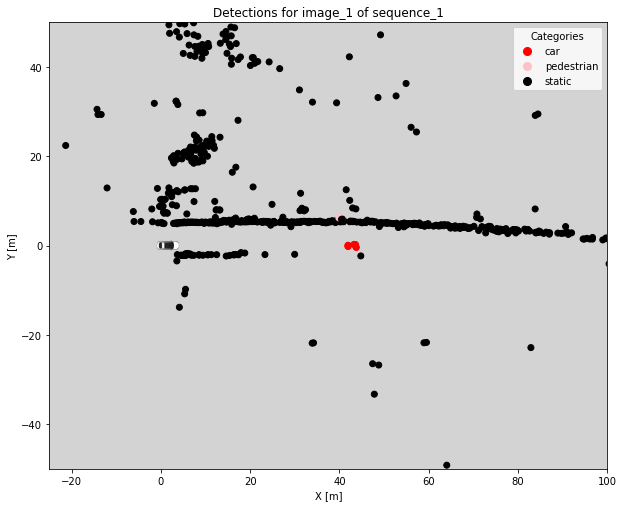

In [388]:
# Dataframe extraction: sequence_1, image_1 detections are considered as example
X = data_gen_pipeline.named_steps['extract'].fit_transform(["sequence_1"])
X = data_gen_pipeline.named_steps['scale_conv'].fit_transform(X)
X = data_gen_pipeline.named_steps['outlayer'].fit_transform(X)

X = X[X.index.get_level_values('image') == 'image_1']

# Create a color map for each category
category_colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple', 5: 'brown', 6: 'cyan', 7: 'pink', 8: 'gray',
                   9: 'yellow', 10: 'magenta', 11: 'black'}

label_map = {0: 'car', 1: 'large vehicle', 2: 'truck', 3: 'bus', 4: 'train', 5: 'bicycle', 6: 'motorized two-wheeler',
             7: 'pedestrian', 8: 'group of pedestrians', 9: 'animal', 10: 'other', 11: 'static'}

# Assign a color to each point based on the category
point_colors = [category_colors[category] for category in X["label_id"]]

figure, axes = plt.subplots(figsize=(10, 10))
axes.set_facecolor('lightgray')

# Scatter plot
scat_plot = axes.scatter(X['x_cc'], X['y_cc'], c=point_colors)

# Ego-vehicle
image_path = 'carFigure.png'
image = img.imread(image_path)
image_box = [-1, 4.2, -2.5, 2.5]
axes.imshow(image, extent=image_box, zorder=1)

axes.set_xlim(-25, 100)
axes.set_ylim(-50, 50)
axes.set_xlabel('X [m]')
axes.set_ylabel('Y [m]')
axes.set_title('Detections for image_1 of sequence_1')

# Create a legend
handles = [plt.Line2D([], [], marker='o', markersize=8, color=color, linestyle='', label=label_map[category])
           for category, color in category_colors.items() if category in X["label_id"].unique()]

# Add the legend to the plot
axes.legend(handles=handles, title='Categories')

plt.show()

As we can see from the graph, most detections are related to static objects. The detections of the car object in front of the car are close one to the other and quite far from detections related to other objects, so they should be easily clustered. The same could not be said for the pedestrian detection, because it is surrounded by a lot of 'static' objects detections.<br>

Only spatial data are not suitable to perform clustering, so we will provide to the clustering algorithm all the object-related features to augment the dimensionality of the space under analysis: space coordinates, RCS and target speed.<br>

The remaining columns of the dataframe will be provided directly to the classification algorithm, wishing that they will be interpreted as "measures" reliability indices.

The clustering algorithm that we will use is the DBSCAN, directly from sklearn library. The DBSCAN is preferred in this application over the K-Means algorithm since we do not know a priori the number of clusters, having no clue on how many object will be present in each "image". One main requirement of the DBSCAN algorithm is that all the clusters are dense, with lots of occurrences in the neighborhood of a "core-instance", and that the clusters are well separated by low-density regions. The first hypothesis is critical in our application since the number of detection for each object could be low, as demonstrated by the previous graph.<br>

In the following we test briefly the performance of the algorithm on the previous image from our first sequence:

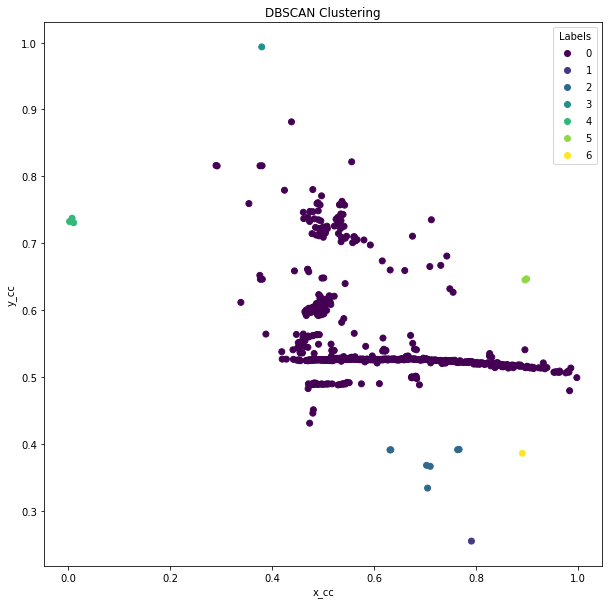

In [454]:
# DBSCAN 
dbscan = DBSCAN(eps=0.1, min_samples=1)

# Data extraction from sequence_1
test_data = data_gen_pipeline.fit_transform(["sequence_1"])
test_data = test_data.loc[test_data.index.get_level_values('image') == 'image_1', ['rcs', 'vr_compensated', 'x_cc', 'y_cc']]

# Launch the clustering algorithm
dbscan.fit(test_data)

# Extract labels for the image detections
lab = dbscan.labels_

# Coordinates of the detections for image_1
detect_coord = test_data.loc[test_data.index.get_level_values('image') == 'image_1', ['x_cc', 'y_cc']]

figure, axes = plt.subplots(figsize=(10, 10))
graph = axes.scatter(detect_coord['x_cc'], detect_coord['y_cc'], c=lab)
axes.set_xlabel('x_cc')
axes.set_ylabel('y_cc')
axes.set_title('DBSCAN Clustering')

# Legend
handles, labels = graph.legend_elements()
legend = axes.legend(handles, labels, title='Labels', loc='best')

plt.show()

As seen, even with a little parameter tuning it is quite difficult for the algorithm to correctly identify the car and the pedestrian in the image.<br> 
We will try to correct this behavior by considering two additional hyperparameters, one weigth for the "rcs" feature in input to the DBSCAN and one for the "vr_compensated" feature. This should properly balance the contributes to the clustering algorithm brought by the coordinate informations, the detection rcs and radial speed. The DBSCAN parameters eps and min_samples will also be hyperparameters and they will be determined, as the others, via grid search cross validation.<br>

Since the reliability of the clustering algorithm seems to be low, we will provide to the classification net all the detections of the image and we will use the cluster labels as additional feature, as a suggestion to the classification net from the clustering algorithm.

## Classification

Our application requires to classify each detection choosing between 11 different possibilities: it is a problem of multiclass classification.<br>

With keras from tensorflow we can start to build our neural network model.<br>
By adopting a neural network, the number of input and output neurons are already fixed since one input neuron for input feature and one output neuron for category are necessary.<br>
A high number of hidden layers permits to treat complex problems where it is necessary to extract key features progressively but our problem should not be classified as a highly structured problem (while considering our approch), so we choose to use only a 2 hidden level neural network.<br>
The number of neurons for the first hidden layer should be high enough to permit an expansion, a rearrangement of our input features in a simpler form. Deep neural networks first layers should theoretically rearrange the features in the most elementary possible representation, to perform in the following layers an elaboration of those "elementary bricks" to achieve the desidered purpose.<br>
The number of neurons per layers is a hyperparameter of the model, so we can start with an initial hypothesis that will be refined later using grid search: a number of neurons equal to 100 for the first hidden layer and 50 for the second one should do the job.<br>
The activation function for all the neurons, except for the output layer, will be a classical choice: the ReLU. As output we would like to obtain a prediction that represents the probability that the detection belongs to each class and, since our class are mutually exclusive, we can use the softmax activation function.
After all the hidden layers we place a batch normalization layer that will help to mantain all input features to each layers normalized. The assembled net cannot be considered deep with only tho hidden layers, so problems like exploding or vanishing gradient should not occur, but include the batch normalization layers is always a good habit. In our case one benefit of the batch normalization layers is that, at a little cost in terms of parameters, all layers will have normalized input and so could be initialized and treated in the same way.
As initialization for the hidden layers we choose the "He normal" method, which is an extension of the Glorot method and it has been developed for the ReLU activation function layers. The He normal method initialize all layer's weights according to a gaussian distribution with mean 0 and standard deviation proportional to the number of inputs of the layer.

In [486]:
net = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[1, 8]),    
      keras.layers.Dense(100, activation='relu',kernel_initializer="he_normal"),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(50, activation='relu',kernel_initializer="he_normal"),
      keras.layers.BatchNormalization(),
      keras.layers.Dense(12, activation="softmax")
      ])

net.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 8)                 0         
                                                                 
 dense_27 (Dense)            (None, 100)               900       
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_28 (Dense)            (None, 50)                5050      
                                                                 
 batch_normalization_3 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_29 (Dense)            (None, 12)               

Since our problem is a multiclass classification one, the proper loss function to use is the categorical cross entropy, i.e. the multiclass generalization of the logistic cost function.<br>
As optimizer we choose the Nesterov gradient acceleration extension of the stochastic gradient descent method. This method applies the gradient acceleration by evaluating the gradient in the "next" point, pointed by the gradient descent algorithm with momentum optimization.<br>
The learning rate scheduling adopted is the "ReduceLROnPlateau" from keras, with which the learning rate is reduced of the specified factor each time that the loss error does not decrease for a number of epochs equal to the patience value.<br>
As regularization we adopt the early stopping method, that will stop training if the net starts overfitting and presents an increasing validation error. With the parameter "restore_best_weights = True" the net weights of the minimum validation error case are returned as optimum ones.<br>

In [490]:
reduceLR = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', factor = 0.5, patience = 7, min_lr = 1e-12)
early_stop = keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience = 50, mode = 'min', restore_best_weights = True, min_delta = 0.001)

net.compile(loss="CategoricalCrossentropy",
            optimizer=keras.optimizers.SGD(learning_rate = 0.001, momentum = 0.01, nesterov = True),
            metrics=["accuracy"])

callbacks = [reduceLR, early_stop]

First we train the proposed net without considering the dbscan clustering algorithm contribution, to obtain a base case to compare with the further developments.<br>
Since we do not know the optimal parameters of the net, like the number of neurons per layer or the Nesterov momentum, we pack all our net initialization commands in an estimator class that will properly set the net accordingly to its input parameters. With this workaround we will be able to perform a randomized search on a predefined parameters grid, using cross validation to identify the best set over the explored ones. Later we will use the same algorithm to determine the best parameters for the clustering algorithm.

In [491]:
class netEstimator(BaseEstimator):
  
    def __init__(self, learning_rate = 0.001, momentum=0.01, epochs=500, first_neurons=100, second_neurons=50):
        
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.epochs = epochs
        self.first_neurons = first_neurons
        self.second_neurons = second_neurons
    
    def fit(self, X, y):
        
        self.net = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[1, 8]),    
        keras.layers.Dense(self.first_neurons, activation='relu',kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(self.second_neurons, activation='relu',kernel_initializer="he_normal"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(12, activation="softmax")
        ])
        
        self.nest = keras.optimizers.SGD(learning_rate = self.learning_rate, momentum = self.momentum, nesterov = True)
        self.net.compile(loss="CategoricalCrossentropy", optimizer= self.nest, metrics=["accuracy"])
        
        self.net.fit(X,y, epochs = self.epochs, callbacks = callbacks)
        return self.net

    def predict(self, X):
        return self.net.predict(X)

From now on the code will be executed on Google Colab, that will permit to speed up the process and to treat all our data at once.

In [500]:
from IPython.display import display, HTML

notebook_file_id = 'https://drive.google.com/file/d/1Gd1ASjTZaIfhTQiwGy8BKkMuO-qyxRez/view?usp=drive_link'

colab_link = f'<a href="https://colab.research.google.com/drive/{notebook_file_id}" target="_parent">Open in Colab</a>'
display(HTML(colab_link))

In [497]:
net.fit(X_df,Y_df, batch_size = X_df.shape[0], callb = [reduceLR, early_stop])

TypeError: fit() got an unexpected keyword argument 'callb'

In [483]:
# DBSCAN 
dbscan = DBSCAN(eps=0.1, min_samples=1)

# Training data selection
train_seqs = seq_df[seq_df['category'] == 'train'].index.values

# Features and targets columns
target_list =  ['car','large vehicle','truck','bus','train','bicycle','motorized two-wheeler',
                        'pedestrian','group of pedestrians','animal','other','static']
feature_list = ['range_sc','azimuth_sc','rcs','vr_compensated','x_cc','y_cc','vx','yaw_rate','cluster']

for sequence_name in train_seqs:
    
    train_df = data_gen_pipeline.fit_transform([sequence_name])
    test_data = test_data.loc[test_data.index.get_level_values('image') == 'image_1', ['rcs', 'vr_compensated', 'x_cc', 'y_cc']]

    # Net training on each image
    images = train_df.index.get_level_values('image').unique()
    
    for image_name in images:
        
        image_df = train_df.loc[train_df.index.get_level_values('image') == image_name]
        
        # Clustering fit on the image
        dbscan.fit(image_df[['rcs', 'vr_compensated', 'x_cc', 'y_cc']])
        image_df.insert(len(image_df.columns), 'cluster', dbscan.labels_)
        
        # Features and targets dataframes
        X_df = image_df[feature_list]
        Y_df = image_df[target_list]
        
        net.fit(X_df,Y_df, batch_size = X_df.shape[0])

Epoch 1/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1858 - accuracy: 0.9824
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1811 - accuracy: 0.9824
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1768 - accuracy: 0.9824
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1729 - accuracy: 0.9824


<ipython-input-483-b697e71d49f7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["cluster"] = dbscan.labels_


Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1690 - accuracy: 0.9808
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1644 - accuracy: 0.9808
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1601 - accuracy: 0.9824
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1559 - accuracy: 0.9808
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1531 - accuracy: 0.9808
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1491 - accuracy: 0.9824
Epoch 11/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1450 - accuracy: 0.9824
Epoch 12/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1409 - accuracy: 0.9824
Epoch 13/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1379 - accuracy: 0.9824
Epoch 14/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1346 - accuracy: 0.9824
Epoch

Epoch 87/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0654 - accuracy: 0.9888
Epoch 88/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0653 - accuracy: 0.9888
Epoch 89/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0651 - accuracy: 0.9888
Epoch 90/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.9888
Epoch 91/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0648 - accuracy: 0.9888
Epoch 92/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0647 - accuracy: 0.9888
Epoch 93/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0645 - accuracy: 0.9888
Epoch 94/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0642 - accuracy: 0.9888
Epoch 95/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0641 - accuracy: 0.9888
Epoch 96/100
20/20 [==============================] - 0s 1ms/step - loss: 0.0639 - accuracy: 0.9888


<ipython-input-483-b697e71d49f7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["cluster"] = dbscan.labels_


Epoch 3/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0367 - accuracy: 0.9888
Epoch 4/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0363 - accuracy: 0.9883
Epoch 5/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0362 - accuracy: 0.9900
Epoch 6/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0362 - accuracy: 0.9888
Epoch 7/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0361 - accuracy: 0.9888
Epoch 8/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0360 - accuracy: 0.9877
Epoch 9/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0357 - accuracy: 0.9888
Epoch 10/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0366 - accuracy: 0.9866
Epoch 11/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0358 - accuracy: 0.9877
Epoch 12/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0355 - accuracy: 0.9883
Epoch 1

Epoch 85/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9877
Epoch 86/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9894
Epoch 87/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0334 - accuracy: 0.9888
Epoch 88/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.9883
Epoch 89/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.9911
Epoch 90/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0333 - accuracy: 0.9900
Epoch 91/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0333 - accuracy: 0.9872
Epoch 92/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.9905
Epoch 93/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.9916
Epoch 94/100
57/57 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.9894


<ipython-input-483-b697e71d49f7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["cluster"] = dbscan.labels_


Epoch 3/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0332 - accuracy: 0.9885
Epoch 4/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.9885
Epoch 5/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.9897
Epoch 6/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0330 - accuracy: 0.9891
Epoch 7/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.9879
Epoch 8/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.9921
Epoch 9/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0328 - accuracy: 0.9873
Epoch 10/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0327 - accuracy: 0.9885
Epoch 11/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0326 - accuracy: 0.9921
Epoch 12/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0325 - accuracy: 0.9891
Epoch 1

Epoch 85/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.9933
Epoch 86/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0309 - accuracy: 0.9903
Epoch 87/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0310 - accuracy: 0.9945
Epoch 88/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0309 - accuracy: 0.9909
Epoch 89/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.9927
Epoch 90/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0309 - accuracy: 0.9945
Epoch 91/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.9915
Epoch 92/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.9933
Epoch 93/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.9927
Epoch 94/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0308 - accuracy: 0.9915


<ipython-input-483-b697e71d49f7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["cluster"] = dbscan.labels_


50/50 [==============================] - 0s 1ms/step - loss: 0.0392 - accuracy: 0.9873
Epoch 4/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0392 - accuracy: 0.9866
Epoch 5/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0391 - accuracy: 0.9866
Epoch 6/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0389 - accuracy: 0.9847
Epoch 7/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0390 - accuracy: 0.9892
Epoch 8/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0387 - accuracy: 0.9892
Epoch 9/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0390 - accuracy: 0.9860
Epoch 10/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0388 - accuracy: 0.9873
Epoch 11/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0388 - accuracy: 0.9873
Epoch 12/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0388 - accuracy: 0.9879
Epoch 13/100
50/50 

50/50 [==============================] - 0s 1ms/step - loss: 0.0370 - accuracy: 0.9879
Epoch 86/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0369 - accuracy: 0.9905
Epoch 87/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0371 - accuracy: 0.9879
Epoch 88/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0369 - accuracy: 0.9886
Epoch 89/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9943
Epoch 90/100
50/50 [==============================] - 0s 1ms/step - loss: 0.0368 - accuracy: 0.9879
Epoch 91/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9866
Epoch 92/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0366 - accuracy: 0.9898
Epoch 93/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0368 - accuracy: 0.9860
Epoch 94/100
50/50 [==============================] - 0s 2ms/step - loss: 0.0367 - accuracy: 0.9892
Epoch 95/100


<ipython-input-483-b697e71d49f7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["cluster"] = dbscan.labels_


52/52 [==============================] - 0s 1ms/step - loss: 0.0265 - accuracy: 0.9933
Epoch 3/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9909
Epoch 4/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0262 - accuracy: 0.9933
Epoch 5/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0263 - accuracy: 0.9939
Epoch 6/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0262 - accuracy: 0.9951
Epoch 7/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0261 - accuracy: 0.9915
Epoch 8/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0260 - accuracy: 0.9957
Epoch 9/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0261 - accuracy: 0.9915
Epoch 10/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0262 - accuracy: 0.9933
Epoch 11/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0261 - accuracy: 0.9927
Epoch 12/100
52/52 [

52/52 [==============================] - 0s 1ms/step - loss: 0.0253 - accuracy: 0.9945
Epoch 85/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0251 - accuracy: 0.9933
Epoch 86/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0250 - accuracy: 0.9976
Epoch 87/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0251 - accuracy: 0.9945
Epoch 88/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0252 - accuracy: 0.9970
Epoch 89/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0250 - accuracy: 0.9939
Epoch 90/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0250 - accuracy: 0.9963
Epoch 91/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0252 - accuracy: 0.9939
Epoch 92/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0251 - accuracy: 0.9945
Epoch 93/100
52/52 [==============================] - 0s 1ms/step - loss: 0.0250 - accuracy: 0.9976
Epoch 94/100


<ipython-input-483-b697e71d49f7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["cluster"] = dbscan.labels_


53/53 [==============================] - 0s 2ms/step - loss: 0.0490 - accuracy: 0.9935
Epoch 3/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0488 - accuracy: 0.9929
Epoch 4/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0485 - accuracy: 0.9935
Epoch 5/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0483 - accuracy: 0.9929
Epoch 6/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0481 - accuracy: 0.9917
Epoch 7/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0482 - accuracy: 0.9935
Epoch 8/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0479 - accuracy: 0.9929
Epoch 9/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0478 - accuracy: 0.9929
Epoch 10/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0477 - accuracy: 0.9929
Epoch 11/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0476 - accuracy: 0.9935
Epoch 12/100
53/53 [

53/53 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.9917
Epoch 85/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.9923
Epoch 86/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0438 - accuracy: 0.9941
Epoch 87/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9912
Epoch 88/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9935
Epoch 89/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9941
Epoch 90/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0436 - accuracy: 0.9923
Epoch 91/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9917
Epoch 92/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9935
Epoch 93/100
53/53 [==============================] - 0s 2ms/step - loss: 0.0435 - accuracy: 0.9929
Epoch 94/100


<ipython-input-483-b697e71d49f7>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_df["cluster"] = dbscan.labels_


49/49 [==============================] - 0s 1ms/step - loss: 0.1177 - accuracy: 0.9896
Epoch 3/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1171 - accuracy: 0.9896
Epoch 4/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1163 - accuracy: 0.9890
Epoch 5/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1155 - accuracy: 0.9890
Epoch 6/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1147 - accuracy: 0.9896
Epoch 7/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1144 - accuracy: 0.9890
Epoch 8/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1136 - accuracy: 0.9890
Epoch 9/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1131 - accuracy: 0.9883
Epoch 10/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1125 - accuracy: 0.9896
Epoch 11/100
49/49 [==============================] - 0s 1ms/step - loss: 0.1124 - accuracy: 0.9883
Epoch 12/100
49/49 [

KeyboardInterrupt: 

--------------------------------------------------------------------------------------------------------------------------------